# Tourist Accommodations Data

**Objective**  
This part is dedicated to Data Wrangling and EDA of tourist accommodation dataset.

**Description and characteristics of dataset**  
Tourist rental property listings on major platforms.

The characteristics of this dataset are as follows:
- Estimated volume: 25,000 records every 7 days
- Historical data: Available from 2017-01

**Data description**  
[Data description](https://datamarket.es/#alojamientos-turisticos-dataset)  
[Data overview (number of non missing values, unique, missing values)](https://github.com/ITACADEMYprojectes/ProjecteData/blob/main/Equip_F/Data/data_overview.xlsx)

In [39]:
# import libraries 
import os
import re
import warnings

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sqlalchemy

from download_data import get_latest_table

from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler

warnings.filterwarnings("ignore")

In [40]:
# font sizes
plt.rcParams['figure.titlesize'] = 18 
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['font.size'] = 14             
plt.rcParams['axes.labelsize'] = 14  

plt.rcParams['xtick.labelsize'] = 12      
plt.rcParams['ytick.labelsize'] = 12       
plt.rcParams['legend.fontsize'] = 12

# display settings
#pd.set_option('display.max_colwidth', 100)
pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', 50)
pd.set_option('display.float_format', '{:.2f}'.format)
 
# set palette
sns.set_palette('Paired')

sns.set_style("darkgrid")

In [41]:
# check versions of libraries
def lib_versions(libs):
    for lib in libs: print('Version', lib.__name__, '-', lib.__version__)

lib_versions([np, pd, mpl, sns])

Version numpy - 1.25.2
Version pandas - 2.0.3
Version matplotlib - 3.10.0
Version seaborn - 0.13.2


## Data Loading

In [42]:
# load environment variables
dotenv_path = find_dotenv()
if dotenv_path:
    load_dotenv(dotenv_path)
else:
    print(".env file not found")

# MySQL configuration
CONFIG = {
    'user': os.getenv('MYSQL_USER'),
    'password': os.getenv('MYSQL_PASSWORD'),
    'host': os.getenv('HOST'),
    'database': 'Equip_F',
    'raise_on_warnings': True
}

In [43]:
# fetch latest table and its name
latest_table, df = get_latest_table(CONFIG)

Total rows in table Tourist_Accommodation31032025: 8000
MySQL connection closed


In [44]:
if df is not None:
    print(f'Latest table: {latest_table}')
    display(df)
else:
    print('No dataframe was fetched')

Latest table: Tourist_Accommodation31032025


,apartment_id,name,description,host_id,neighbourhood_name,neighbourhood_district,room_type,accommodates,bathrooms,bedrooms,beds,amenities_list,price,minimum_nights,maximum_nights,has_availability,availability_30,availability_60,availability_90,availability_365,number_of_reviews,first_review_date,last_review_date,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,is_instant_bookable,reviews_per_month,country,city,insert_date
0,11964,A ROOM WITH A VIEW,Private bedroom in our attic apartment. Right ...,45553,Centro,None,Private room,2,2,1,1.00,"TV,Internet,Wifi,Air conditioning,Elevator,Buz...",400.00,3,365,VERDADERO,7,20,40,130,78,02/01/2010,05/09/2017,970.00,100.00,100.00,100.00,100.00,100.00,100.00,FALSO,75.00,spain,malaga,31/07/2018
1,21853,Bright and airy room,We have a quiet and sunny room with a good vie...,83531,C�rmenes,Latina,Private room,1,1,1,1.00,"TV,Internet,Wifi,Air conditioning,Kitchen,Free...",170.00,4,40,VERDADERO,0,0,0,162,33,10/10/2014,15/07/2018,920.00,90.00,90.00,100.00,100.00,80.00,90.00,FALSO,52.00,spain,madrid,10/01/2020
2,32347,Explore Cultural Sights from a Family-Friendly...,Open French doors and step onto a plant-filled...,139939,San Vicente,Casco Antiguo,Entire home/apt,4,1,2,2.00,"TV,Internet,Wifi,Air conditioning,Wheelchair a...",990.00,2,120,VERDADERO,26,31,31,270,148,05/01/2011,22/07/2019,980.00,100.00,100.00,100.00,100.00,100.00,100.00,VERDADERO,142.00,spain,sevilla,29/07/2019
3,35379,Double 02 CasanovaRooms Barcelona,Room at a my apartment. Kitchen and 2 bathroom...,152232,l'Antiga Esquerra de l'Eixample,Eixample,Private room,2,2,1,1.00,"TV,Internet,Wifi,Kitchen,Breakfast,Elevator,Bu...",400.00,2,730,VERDADERO,9,23,49,300,292,13/03/2012,04/01/2020,940.00,100.00,90.00,100.00,100.00,100.00,90.00,VERDADERO,306.00,spain,barcelona,10/01/2020
4,35801,Can Torras Farmhouse Studio Suite,Lay in bed & watch sunlight change the mood of...,153805,Quart,None,Private room,5,1,2,5.00,"Wifi,Pool,Free parking on premises,Breakfast,P...",900.00,1,180,VERDADERO,0,19,49,312,36,08/07/2011,08/08/2018,970.00,100.00,100.00,100.00,100.00,100.00,100.00,FALSO,39.00,spain,girona,19/02/2019
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7995,32392193,Espectacular habitaci�n,None,238089984,Sant Antoni,Eixample,Private room,1,1,1,1.00,"TV,Wifi,Elevator,Heating,Washer,Essentials,Sha...",3000.00,32,1125,VERDADERO,28,58,88,363,0,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,VERDADERO,NaN,spain,barcelona,16/10/2019
7996,32392774,? Tu Hogar de Lujo ????? en el Centro de Sevilla,"Exclusivo, amplio y luminoso alojamiento situa...",243246681,Arenal,Casco Antiguo,Entire home/apt,6,2,3,4.00,"Patio or balcony, Long term stays allowed, Sha...",2090.00,2,60,VERDADERO,0,11,41,41,36,17/03/2019,09/09/2020,1000.00,100.00,100.00,100.00,100.00,100.00,100.00,FALSO,157.00,spain,sevilla,31/01/2021
7997,32395123,Rooms by G Bella Mar�a 3,The 2-star Bella Maria has 24-hourreception an...,159933359,Felanitx,None,Entire home/apt,2,1,1,2.00,"Air conditioning,Pool,Kitchen,Free parking on ...",930.00,1,1125,VERDADERO,23,53,83,184,0,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,VERDADERO,NaN,spain,mallorca,24/04/2019
7998,32407332,LUMINOSO Y ENCANTADOR PISO CERCA DE TODO,PISO MUY ILUMINADO CON UNA TERRAZA ESTUPENDA C...,187631805,Proven�als del Poblenou,Sant Mart�,Private room,3,2,2,2.00,"TV,Wifi,Air conditioning,Kitchen,Free parking ...",960.00,2,15,VERDADERO,1,17,40,315,21,04/03/2019,28/07/2019,980.00,100.00,100.00,100.00,100.00,100.00,100.00,VERDADERO,389.00,spain,barcelona,12/08/2019


## Data Overview

In [45]:
# define function to display information about the data
def data_info(df):
   
    """Input: dataframe.
    Function displays basic information, 
    checks for duplicates and NaN. 
    """
    
    # get information about the data
    print(df.info())
    
    # number of unique values for each column
    print()
    print('\033[1mNumber of unique values')
    display(df.nunique())

    # check for NaN
    if df.isna().sum().sum() > 0:
        print()
        print('\033[1mNumber of missing values')
        display(
            pd.DataFrame({'number': df.isna().sum(), 
                          'percentage': df.isna().mean().mul(100)})
            .query('number > 0')
            .sort_values(by='number', ascending=False)
        )
    else:
        print('There are no NaNs in the data\n')
    
    # check for duplicates (without id columns)
    print()
    if df.iloc[:,1:].duplicated().sum() > 0:
        print('Data contain full duplicates\n')
    else:
        print('There are no full duplicates in the data\n')

In [46]:
data_info(df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 35 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   apartment_id                 8000 non-null   int64  
 1   name                         7997 non-null   object 
 2   description                  7946 non-null   object 
 3   host_id                      8000 non-null   int64  
 4   neighbourhood_name           8000 non-null   object 
 5   neighbourhood_district       4861 non-null   object 
 6   room_type                    8000 non-null   object 
 7   accommodates                 8000 non-null   int64  
 8   bathrooms                    7957 non-null   object 
 9   bedrooms                     7961 non-null   object 
 10  beds                         7992 non-null   float64
 11  amenities_list               7983 non-null   object 
 12  price                        7829 non-null   float64
 13  minimum_nights    

apartment_id                   7693
name                           7714
description                    7736
host_id                        5888
neighbourhood_name              492
neighbourhood_district           61
room_type                         4
accommodates                     20
bathrooms                        13
bedrooms                         14
beds                             24
amenities_list                 7750
price                           392
minimum_nights                   41
maximum_nights                  135
has_availability                  1
availability_30                  31
availability_60                  61
availability_90                  91
availability_365                366
number_of_reviews               319
first_review_date              1938
last_review_date               1476
review_scores_rating             46
review_scores_accuracy            9
review_scores_cleanliness         9
review_scores_checkin             8
review_scores_communication 


Number of missing values


,number,percentage
neighbourhood_district,3139,39.24
review_scores_value,1711,21.39
review_scores_location,1711,21.39
review_scores_checkin,1710,21.38
review_scores_accuracy,1705,21.31
review_scores_communication,1701,21.26
review_scores_cleanliness,1699,21.24
review_scores_rating,1696,21.20
last_review_date,1615,20.19
first_review_date,1614,20.18



There are no full duplicates in the data



In [47]:
# country and cities of accomodations
df.country.unique(), df.city.unique()

(array(['spain'], dtype=object),
 array(['malaga', 'madrid', 'sevilla', 'barcelona', 'girona', 'valencia',
        'mallorca', 'menorca'], dtype=object))


---

The dataset contains 8000 rows and 35 columns.
The unique values in country and city confirm that the dataset focuses on Spain, covering six cities—'Malaga', 'Madrid', 'Sevilla', 'Barcelona', 'Girona', and 'Valencia'—as well as two islands: 'Mallorca' and 'Menorca'.

*Missing Values*
- 171 rows lack a `price` value.
- The `neighbourhood_district` column has 3139 missing values (~39% of the data).
- Review-related columns have between 1614 and 1711 missing values.
- 550 rows are missing `has_availability` information.

*Duplicates*
- 299 duplicate values in `apartment_id`.
- 286 duplicate values in `name`.
- 264 duplicate values in `description`.
- 250 duplicate values in `amenities_list`.

*Text format issues*  
The presence of � (replacement characters) in string columns is likely due to incorrect encoding, which prevents proper display of special characters (e.g., Spanish accents: á, é, í, ó, ú, ñ).

**Conclusion**  
Before performing an exhaustive EDA, several data quality issues need to be addressed:  
*Missing Values*
- The missing `price` values should be investigated, as they directly impact the marketing business task.
- NaN values in `has_availability` can be treated as 'False', and depending on the business needs, these rows may be dropped.
- Missing values in other columns are not critical for Sprint_1 and do not affect KPIs.

*Duplicates*  
Duplicate apartment_id, name, and description should be analyzed. It's unusual for different apartments to have the same descriptions, which may indicate data inconsistencies or incorrect entries.

## Data Cleaning

### Data Type

- 'Date' columns have not proper datetime format, let's change it.

In [49]:
df[['first_review_date', 'last_review_date', 'insert_date']]

,first_review_date,last_review_date,insert_date
0,02/01/2010,05/09/2017,31/07/2018
1,10/10/2014,15/07/2018,10/01/2020
2,05/01/2011,22/07/2019,29/07/2019
3,13/03/2012,04/01/2020,10/01/2020
4,08/07/2011,08/08/2018,19/02/2019
...,...,...,...
7995,None,None,16/10/2019
7996,17/03/2019,09/09/2020,31/01/2021
7997,None,None,24/04/2019
7998,04/03/2019,28/07/2019,12/08/2019


In [50]:
# convert to datetime
df['first_review_date'] = pd.to_datetime(df['first_review_date'], format='%d/%m/%Y')
df['last_review_date'] = pd.to_datetime(df['last_review_date'], format='%d/%m/%Y')
df['insert_date'] = pd.to_datetime(df['insert_date'], format='%d/%m/%Y')

df[['first_review_date', 'last_review_date', 'insert_date']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   first_review_date  6386 non-null   datetime64[ns]
 1   last_review_date   6385 non-null   datetime64[ns]
 2   insert_date        8000 non-null   datetime64[ns]
dtypes: datetime64[ns](3)
memory usage: 187.6 KB


- The column `is_instant_bookable` contains values 'FALSO' and 'VERDADERO'. To simplify calculations, let's convert them to 0 and 1, respectively.

In [51]:
df['is_instant_bookable'].value_counts(dropna=False)

is_instant_bookable
VERDADERO    4439
FALSO        3561
Name: count, dtype: int64

In [52]:
# 'FALSO' -> "0", 'VERDADERO' -> "1"
df['is_instant_bookable'] = np.where(df['is_instant_bookable'] == 'VERDADERO', 1, 0)

df['is_instant_bookable'].value_counts(dropna=False)

is_instant_bookable
1    4439
0    3561
Name: count, dtype: int64

### Duplicates

First, let's handle duplicates—removing them might also eliminate listings with missing prices.

In [53]:
print('Number of objects with 1 or more duplicates')
(df['apartment_id'].value_counts()>1).sum()

Number of objects with 1 or more duplicates


299

In [54]:
df['apartment_id'].value_counts().head(20)

apartment_id
15402794    3
32161182    3
10005342    3
10713417    3
14582385    3
14326808    3
13966456    3
24038577    3
27727159    2
27702437    2
3942375     2
27775898    2
3770072     2
15885378    2
15907725    2
27929937    2
27945716    2
27948909    2
4026797     2
27801720    2
Name: count, dtype: int64

In [55]:
df[df.apartment_id==15402794]

,apartment_id,name,description,host_id,neighbourhood_name,neighbourhood_district,room_type,accommodates,bathrooms,bedrooms,beds,amenities_list,price,minimum_nights,maximum_nights,has_availability,availability_30,availability_60,availability_90,availability_365,number_of_reviews,first_review_date,last_review_date,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,is_instant_bookable,reviews_per_month,country,city,insert_date
3125,15402794,R1- Single room next to the council,Single bedroom in a symbolic building in the ...,97743716,SANT FRANCESC,CIUTAT VELLA,Private room,1,2,1,1.00,"Wifi,Elevator,Heating,Family/kid friendly,Firs...",150.00,1,1125,VERDADERO,8,25,50,297,85,2016-11-01,2019-07-01,920.00,100.00,100.00,100.00,100.00,100.00,90.00,0,254.00,spain,valencia,2019-07-31
3126,15402794,R1- Single room next to the council,Single bedroom in a symbolic building in the ...,97743716,SANT FRANCESC,CIUTAT VELLA,Private room,1,2,1,1.00,"Shampoo, Fire extinguisher, Elevator, First ai...",190.00,1,1125,VERDADERO,28,55,85,360,105,2016-11-01,2020-08-15,920.00,100.00,100.00,100.00,100.00,100.00,90.00,0,22.00,spain,valencia,2020-09-28
3127,15402794,R1- Single room next to the council,Single bedroom in a symbolic building in the ...,97743716,SANT FRANCESC,CIUTAT VELLA,Private room,1,2,1,1.00,"Wifi,Elevator,Heating,Family/kid friendly,Firs...",150.00,1,1125,VERDADERO,26,50,69,313,103,2016-11-01,2020-03-09,920.00,100.00,100.00,100.00,100.00,100.00,90.00,0,247.00,spain,valencia,2020-03-26


Some objects with the same `apartment_id` have 1 or even 2 duplicates recorded on different `insert_date` values. Let's check whether they also share the same name and location, as it's possible for different properties to have the same name but be in different places.

In [56]:
res = (df[df['apartment_id'].duplicated(keep=False)]
       .groupby('apartment_id')[['name', 'description', 'room_type', 'host_id', 'city', 'insert_date']]
       .nunique())

res

,name,description,room_type,host_id,city,insert_date
apartment_id,,,,,,
144471,1,1,1,1,1,2
157327,1,1,1,1,1,2
343864,1,1,1,1,1,2
503253,1,1,1,1,1,2
886569,1,2,1,1,1,2
...,...,...,...,...,...,...
31309107,2,2,1,1,1,2
31425991,1,1,1,1,1,2
31550517,1,2,1,1,1,2


In [57]:
res[res.insert_date<2]

,name,description,room_type,host_id,city,insert_date
apartment_id,,,,,,


`apartment_id` duplicates always have different `insert_date` → We can keep the most recent entry.

In [58]:
res[res.city>1]

,name,description,room_type,host_id,city,insert_date
apartment_id,,,,,,


`apartment_id` duplicates always belong to the same city → This supports the idea that they are actual duplicates rather than different properties.

In [59]:
res[res.room_type>1]

,name,description,room_type,host_id,city,insert_date
apartment_id,,,,,,
14288527,1,2,2,1,1,2
18682379,2,2,2,1,1,2
24342447,1,1,2,1,1,2


In [60]:
df[df.apartment_id.isin(res[res.room_type>1].index)]

,apartment_id,name,description,host_id,neighbourhood_name,neighbourhood_district,room_type,accommodates,bathrooms,bedrooms,beds,amenities_list,price,minimum_nights,maximum_nights,has_availability,availability_30,availability_60,availability_90,availability_365,number_of_reviews,first_review_date,last_review_date,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,is_instant_bookable,reviews_per_month,country,city,insert_date
2861,14288527,"Great penthouse with terrace, overlooking the sea",-The accommodation meets the Sanitary Cleaning...,34433429,Centro,None,Entire home/apt,2,1,1,1.00,"Free street parking, Garden or backyard, Iron,...",670.00,2,31,VERDADERO,19,49,79,160,237,2016-08-10,2020-10-12,970.00,100.00,100.00,100.00,100.00,100.00,100.00,1,443.00,spain,malaga,2020-12-30
2862,14288527,"Great penthouse with terrace, overlooking the sea","Great penthouse with terrace, overlooking the ...",34433429,Este,None,Private room,2,1,1,1.00,"TV,Internet,Wireless Internet,Pool,Free parkin...",440.00,2,15,VERDADERO,14,18,40,41,102,2016-08-10,2017-11-21,970.00,100.00,100.00,100.00,100.00,90.00,100.00,1,647.00,spain,malaga,2017-11-25
4238,18682379,"Lush, sunny & quiet 2 bedroom apartment",Search no more! Welcome to your spacious 2 bed...,27775148,la Dreta de l'Eixample,Eixample,Entire home/apt,4,1,2,2.00,"Wifi,Kitchen,Breakfast,Elevator,Family/kid fri...",2750.00,4,60,VERDADERO,0,8,8,14,8,2017-07-18,2019-01-01,1000.00,100.00,100.00,100.00,100.00,100.00,90.00,0,44.00,spain,barcelona,2019-01-14
4239,18682379,"Lush, sunny & quiet 2ble room in Barcelona center",Search no more! Welcome to your spacious doubl...,27775148,la Dreta de l'Eixample,Eixample,Private room,2,1,1,1.00,"Wireless Internet,Kitchen,Breakfast,Elevator,F...",650.00,2,20,VERDADERO,0,0,13,288,4,2017-07-18,2017-08-18,1000.00,100.00,100.00,100.00,100.00,100.00,100.00,0,146.00,spain,barcelona,2017-10-07
6262,24342447,Suite Apt 4 pax en Sants,Apartamento con capacidad para 4 personas con ...,3346610,Sants,Sants-Montju�c,Hotel room,4,None,1,4.00,"TV,Internet,Wifi,Air conditioning,Kitchen,Pets...",2000.00,1,1125,VERDADERO,0,16,46,160,8,2018-08-04,2019-10-23,900.00,90.00,90.00,100.00,100.00,100.00,90.00,1,34.00,spain,barcelona,2020-07-17
6263,24342447,Suite Apt 4 pax en Sants,Apartamento con capacidad para 4 personas con ...,3346610,Sants,Sants-Montju�c,Entire home/apt,4,1,1,2.00,"Internet,Wifi,Air conditioning,Free parking on...",1650.00,1,1125,VERDADERO,28,58,88,215,0,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,spain,barcelona,2018-07-10


In [61]:
res[res.host_id>1]

,name,description,room_type,host_id,city,insert_date
apartment_id,,,,,,
19196593,2,2,1,2,1,2


In [62]:
df.query('apartment_id==19196593')

,apartment_id,name,description,host_id,neighbourhood_name,neighbourhood_district,room_type,accommodates,bathrooms,bedrooms,beds,amenities_list,price,minimum_nights,maximum_nights,has_availability,availability_30,availability_60,availability_90,availability_365,number_of_reviews,first_review_date,last_review_date,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,is_instant_bookable,reviews_per_month,country,city,insert_date
4492,19196593,"Centro 4 con garaje gratis, 1 dormitorio",Apartamento de 1 dormitorio con garaje incluid...,18077486,Cruz De Humilladero,None,Entire home/apt,4,1,1,3.00,"Free street parking, Iron, Washer, Hot water, ...",500.00,2,1125,VERDADERO,0,0,0,213,42,2017-06-27,2020-09-05,930.00,100.00,90.00,100.00,100.00,90.00,90.00,1,98.00,spain,malaga,2020-12-30
4493,19196593,"CENTRO 4 CON GARAJE GRATIS, APARTAM. VFT/MA/13723","Supermercado Mercadona a 1 minuto, tiendas y b...",134286611,Bailen-Miraflores,None,Entire home/apt,4,1,1,3.00,"TV,Wifi,Air conditioning,Kitchen,Free parking ...",500.00,2,1125,VERDADERO,0,0,0,181,29,2017-06-27,2018-09-30,940.00,100.00,90.00,100.00,100.00,90.00,90.00,1,16.00,spain,malaga,2018-12-22


In [63]:
df.query('apartment_id==19196593')['name']

4492             Centro 4 con garaje gratis, 1 dormitorio
4493    CENTRO 4 CON GARAJE GRATIS, APARTAM. VFT/MA/13723
Name: name, dtype: object

In [64]:
res[res.name>1]

,name,description,room_type,host_id,city,insert_date
apartment_id,,,,,,
1624014,2,2,1,1,1,2
3163230,2,2,1,1,1,2
3634997,2,2,1,1,1,2
3770072,2,2,1,1,1,2
6584564,2,2,1,1,1,2
7029540,2,1,1,1,1,2
9619438,2,2,1,1,1,2
10806296,2,1,1,1,1,2
12514998,2,2,1,1,1,2


In [65]:
ap_id_dupl_name = res[(res.name>1) & (res.description>1) & (res.host_id<2)].index
df[df.apartment_id.isin(ap_id_dupl_name)]

,apartment_id,name,description,host_id,neighbourhood_name,neighbourhood_district,room_type,accommodates,bathrooms,bedrooms,beds,amenities_list,price,minimum_nights,maximum_nights,has_availability,availability_30,availability_60,availability_90,availability_365,number_of_reviews,first_review_date,last_review_date,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,is_instant_bookable,reviews_per_month,country,city,insert_date
470,1624014,Beautiful apartment to Enjoy the real Barcelona,Recently refurbished modern and spacious 3 bed...,1260560,la Nova Esquerra de l'Eixample,Eixample,Entire home/apt,6,2,3,5.00,"TV,Cable TV,Internet,Wifi,Air conditioning,Kit...",1600.00,3,90,VERDADERO,16,46,76,334,141,2014-04-14,2020-01-06,910.00,90.00,90.00,100.00,100.00,90.00,90.00,1,198.00,spain,barcelona,2020-02-16
471,1624014,Brand-New Low Priced Large Apt 6p,Recently refurbished modern and spacious 3 bed...,1260560,la Nova Esquerra de l'Eixample,Eixample,Entire home/apt,6,2,3,5.00,"TV,Cable TV,Internet,Wireless Internet,Air con...",1870.00,3,1125,None,0,17,47,322,51,2014-04-14,2016-12-04,890.00,90.00,90.00,90.00,90.00,90.00,90.00,1,153.00,spain,barcelona,2017-01-04
758,3163230,Apartment in Sagrada Familia for 4 - WIFI,Bel appartement � 100 m de La Sagrada Familia....,8811801,la Sagrada Fam�lia,Eixample,Entire home/apt,4,1,2,3.00,"Dedicated workspace, Oven, Cooking basics, Dis...",600.00,15,330,VERDADERO,1,31,61,336,39,2014-06-16,2019-10-10,860.00,90.00,90.00,90.00,100.00,90.00,90.00,0,49.00,spain,barcelona,2021-01-12
759,3163230,PISO PARA 5 EN SAGRADA FAMILIA,Piso muy lindo y comodo que puede acoger hasta...,8811801,la Sagrada Fam�lia,Eixample,Entire home/apt,5,1,2,3.00,"TV,Wireless Internet,Kitchen,Elevator in build...",900.00,7,365,None,0,0,0,196,38,2014-06-16,2017-05-18,860.00,90.00,90.00,90.00,100.00,90.00,90.00,1,105.00,spain,barcelona,2017-06-05
855,3634997,"Elegant Apt in Eixample, near Paseo de Gracia",Elegant and Original 160 sqm apartment - 12 pe...,2439400,la Dreta de l'Eixample,Eixample,Entire home/apt,12,2,6,9.00,"TV,Internet,Wifi,Air conditioning,Kitchen,Paid...",3000.00,2,300,VERDADERO,11,19,19,147,34,2014-08-05,2018-03-02,830.00,80.00,90.00,100.00,90.00,90.00,80.00,1,74.00,spain,barcelona,2018-05-14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7105,27702437,MALASA�A **Cute & New Apartment**,Maravilloso apartamento moderno situado en ple...,28786243,Trafalgar,Chamber�,Entire home/apt,4,1,1,1.00,"TV,Wifi,Air conditioning,Kitchen,Elevator,Heat...",600.00,1,1125,VERDADERO,12,28,42,132,7,2018-08-20,2018-10-01,970.00,100.00,100.00,80.00,100.00,100.00,100.00,1,404.00,spain,madrid,2018-10-10
7190,28167692,SAGRADA FAMILIA LOUNGE ONLY FOR FAMILIES,"Sagrada Familia lounge, es una propiedad con u...",212751454,el Fort Pienc,Eixample,Entire home/apt,8,2,4,6.00,"TV,Wifi,Air conditioning,Kitchen,Elevator,Heat...",1300.00,3,20,VERDADERO,4,28,41,41,0,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,spain,barcelona,2018-10-10
7191,28167692,SAGRADA FAMILIA LOUNGE,"Modern, spacious and charming flat in a strate...",212751454,el Fort Pienc,Eixample,Entire home/apt,8,2,4,7.00,"TV,Wifi,Air conditioning,Kitchen,Smoking allow...",1200.00,3,20,VERDADERO,12,28,48,274,3,2018-11-15,2019-01-22,800.00,100.00,100.00,100.00,80.00,100.00,80.00,1,107.00,spain,barcelona,2019-02-06
7768,31309107,Superb Central 2 Bedroom Apt near Pr�ncipe P�o,Renovated 2 bedroom apt with interior balcony ...,234340731,Casa de Campo,Moncloa - Aravaca,Entire home/apt,4,1,2,3.00,"TV,Wifi,Air conditioning,Kitchen,Elevator,Heat...",1250.00,3,30,VERDADERO,16,16,16,16,17,2019-02-27,2019-11-24,1000.00,100.00,100.00,100.00,100.00,100.00,100.00,1,177.00,spain,madrid,2019-12-10


The names vary, but other characteristics remain similar. Sometimes, hosts adjust details, such as reducing the number of guests or changing the listing from a private room to an entire apartment.

Given these factors, we can decide to **retain only the most recent entry for each `apartment_id`** to ensure we have the latest and most relevant data.

#### Remove duplicates

In [66]:
# data with unique apartment_id
df_clean = (df.sort_values(by=['apartment_id', 'insert_date'], ascending=[True, False])
              .drop_duplicates(subset=['apartment_id'], keep='first')
           )

In [67]:
data_info(df_clean)

<class 'pandas.core.frame.DataFrame'>
Index: 7693 entries, 0 to 7999
Data columns (total 35 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   apartment_id                 7693 non-null   int64         
 1   name                         7690 non-null   object        
 2   description                  7643 non-null   object        
 3   host_id                      7693 non-null   int64         
 4   neighbourhood_name           7693 non-null   object        
 5   neighbourhood_district       4669 non-null   object        
 6   room_type                    7693 non-null   object        
 7   accommodates                 7693 non-null   int64         
 8   bathrooms                    7652 non-null   object        
 9   bedrooms                     7654 non-null   object        
 10  beds                         7685 non-null   float64       
 11  amenities_list               7677 non-null   obj

apartment_id                   7693
name                           7667
description                    7610
host_id                        5887
neighbourhood_name              492
neighbourhood_district           61
room_type                         4
accommodates                     20
bathrooms                        13
bedrooms                         14
beds                             24
amenities_list                 7567
price                           389
minimum_nights                   41
maximum_nights                  135
has_availability                  1
availability_30                  31
availability_60                  61
availability_90                  91
availability_365                366
number_of_reviews               318
first_review_date              1938
last_review_date               1467
review_scores_rating             46
review_scores_accuracy            9
review_scores_cleanliness         9
review_scores_checkin             8
review_scores_communication 


Number of missing values


,number,percentage
neighbourhood_district,3024,39.31
review_scores_value,1649,21.44
review_scores_location,1649,21.44
review_scores_checkin,1648,21.42
review_scores_accuracy,1643,21.36
review_scores_communication,1639,21.31
review_scores_cleanliness,1637,21.28
review_scores_rating,1634,21.24
last_review_date,1555,20.21
first_review_date,1554,20.20



There are no full duplicates in the data



In [68]:
print('Number of objects with 1 or more duplicated description')
(df_clean['description'].value_counts()>1).sum()

Number of objects with 1 or more duplicated description


28

In [69]:
print('Number of objects with 1 or more duplicated name')
(df_clean['name'].value_counts()>1).sum()

Number of objects with 1 or more duplicated name


21

---

We still have 121 objects without a price and 16 objects with non-unique names and descriptions. While it is possible for multiple appartments to share the same description—such as when a host owns similar apartments in the same building—these cases should be analyzed further to ensure data accuracy and make informed decisions.

In [71]:
df_clean[df_clean['description'].duplicated(keep=False)].sort_values(by='description').head(20)

,apartment_id,name,description,host_id,neighbourhood_name,neighbourhood_district,room_type,accommodates,bathrooms,bedrooms,beds,amenities_list,price,minimum_nights,maximum_nights,has_availability,availability_30,availability_60,availability_90,availability_365,number_of_reviews,first_review_date,last_review_date,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,is_instant_bookable,reviews_per_month,country,city,insert_date
5119,20950570,1 sleeper place in shared room!,1 sleeper place in shared room with bunk beds!...,73976926,el Bes�s i el Maresme,Sant Mart�,Shared room,1,1,1,1.00,"Internet,Wifi,Kitchen,Elevator,Essentials,Sham...",80.00,1,1125,VERDADERO,17,47,77,352,22,2017-10-05,2019-03-05,890.00,90.00,90.00,100.00,100.00,80.00,90.00,1,119.00,spain,barcelona,2019-04-10
5120,20950596,1 sleeper place in shared room!,1 sleeper place in shared room with bunk beds!...,73976926,el Bes�s i el Maresme,Sant Mart�,Shared room,1,1,1,1.00,"Internet,Wifi,Kitchen,Elevator,Essentials,Sham...",80.00,1,1125,VERDADERO,29,59,89,364,3,2017-10-07,2018-01-19,800.00,80.00,90.00,90.00,100.00,70.00,90.00,1,32.00,spain,barcelona,2018-07-10
7071,27545229,Habitaci�n en paseo maragall,<b>License number</b><br />Exempt,145884948,Horta,Horta-Guinard�,Private room,2,1,1,1.00,"Elevator, Essentials, Hair dryer, Hangers, Ext...",400.00,2,1125,VERDADERO,0,0,0,0,4,2018-08-16,2018-09-07,950.00,100.00,100.00,100.00,100.00,90.00,100.00,1,13.00,spain,barcelona,2021-02-09
6812,26424500,BCN Greatest Location Little Cozy Room,<b>License number</b><br />Exempt,160635054,la Dreta de l'Eixample,Eixample,Private room,1,1,1,1.00,"Wifi, Kitchen, Heating, Dedicated workspace, E...",320.00,3,1125,VERDADERO,0,0,0,0,2,2018-07-02,2018-09-14,600.00,40.00,20.00,60.00,100.00,100.00,40.00,1,6.00,spain,barcelona,2021-01-12
7925,32082385,Cozy room on Barcelona Centre,<b>License number</b><br />Exempt,227992730,la Vila de Gr�cia,Gr�cia,Private room,1,1,1,1.00,"Elevator, Hot water, Free parking on premises,...",500.00,1,1125,VERDADERO,30,60,90,365,1,2019-06-27,2019-06-27,1000.00,100.00,100.00,100.00,100.00,100.00,100.00,1,6.00,spain,barcelona,2020-10-12
4290,18788785,Duplex 3 habitaciones,Alojamiento en pleno centro hotelero de la ciu...,122338166,Lloret de Mar,None,Entire home/apt,9,2,3,9.00,"TV,Cable TV,Wifi,Air conditioning,Pool,Kitchen...",1040.00,2,1125,VERDADERO,1,1,1,1,3,2017-05-28,2017-09-13,1000.00,90.00,80.00,80.00,70.00,90.00,90.00,0,1.00,spain,girona,2019-11-30
4054,18218367,Apartaments Ponent 1 habitacion,Alojamiento en pleno centro hotelero de la ciu...,122338166,Lloret de Mar,None,Entire home/apt,4,1,1,2.00,"TV,Cable TV,Wifi,Air conditioning,Pool,Kitchen...",570.00,2,1125,VERDADERO,27,50,80,120,1,2017-05-09,2017-05-09,1000.00,100.00,100.00,100.00,100.00,100.00,100.00,0,6.00,spain,girona,2018-08-30
6371,24650389,APART 3 MALAGA CAPITAL A 100 MTS DE LA PLAYA,"Apartamento NUEVO, para 4 personas integrado e...",186274606,Carretera de Cadiz,None,Entire home/apt,2,1,1,1.00,"TV,Wifi,Air conditioning,Kitchen,Pets allowed,...",600.00,2,30,VERDADERO,0,28,57,174,7,2018-09-05,2020-02-17,970.00,100.00,100.00,90.00,90.00,90.00,90.00,1,33.00,spain,malaga,2020-05-31
6370,24649658,APART 4 MALAGA CAPITAL A 100 MTS DE LA PLAYA,"Apartamento NUEVO, para 4 personas integrado e...",186274606,Carretera de Cadiz,None,Entire home/apt,5,1,1,3.00,"TV,Cable TV,Wifi,Air conditioning,Kitchen,Pets...",600.00,2,30,VERDADERO,14,23,43,288,1,2018-11-04,2018-11-04,1000.00,100.00,100.00,100.00,100.00,100.00,100.00,1,14.00,spain,malaga,2019-05-30
7684,30970092,"SABINA 8, Platja d'Aro Costa Brava",Apartamento situado en la planta baja ideal pa...,100339062,Castell-Platja d'Aro,None,Entire home/apt,4,1,2,4.00,"TV,Cable TV,Wifi,Pool,Kitchen,Free parking on ...",550.00,4,60,VERDADERO,30,30,30,30,0,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,spain,girona,2019-08-31


In [72]:
df_clean['name'].value_counts().head()

name
Apartaments Ponent 1 habitacion                                  3
Beautiful two bedroom appartment with comunitary swiming-pool    3
VILLA MAR                                                        2
Habitaci�n privada                                               2
New apartment in the center of Malaga                            2
Name: count, dtype: int64

In [73]:
# duplicates of name
df_clean[df_clean['name'].duplicated(keep=False)].sort_values(by='name')

,apartment_id,name,description,host_id,neighbourhood_name,neighbourhood_district,room_type,accommodates,bathrooms,bedrooms,beds,amenities_list,price,minimum_nights,maximum_nights,has_availability,availability_30,availability_60,availability_90,availability_365,number_of_reviews,first_review_date,last_review_date,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,is_instant_bookable,reviews_per_month,country,city,insert_date
5119,20950570,1 sleeper place in shared room!,1 sleeper place in shared room with bunk beds!...,73976926,el Bes�s i el Maresme,Sant Mart�,Shared room,1,1,1,1.00,"Internet,Wifi,Kitchen,Elevator,Essentials,Sham...",80.00,1,1125,VERDADERO,17,47,77,352,22,2017-10-05,2019-03-05,890.00,90.00,90.00,100.00,100.00,80.00,90.00,1,119.00,spain,barcelona,2019-04-10
5120,20950596,1 sleeper place in shared room!,1 sleeper place in shared room with bunk beds!...,73976926,el Bes�s i el Maresme,Sant Mart�,Shared room,1,1,1,1.00,"Internet,Wifi,Kitchen,Elevator,Essentials,Sham...",80.00,1,1125,VERDADERO,29,59,89,364,3,2017-10-07,2018-01-19,800.00,80.00,90.00,90.00,100.00,70.00,90.00,1,32.00,spain,barcelona,2018-07-10
5514,22236049,Amazing villa with swimming-pool,"This villa, located in Ciutadella de Menorca, ...",142946500,Ciutadella de Menorca,None,Entire home/apt,4,1,2,3.00,"TV,Pool,Kitchen,Free parking on premises,Smoki...",1420.00,3,1125,VERDADERO,30,60,90,365,4,2018-06-28,2018-08-22,750.00,80.00,90.00,90.00,90.00,70.00,80.00,1,55.00,spain,menorca,2019-01-30
5877,23284722,Amazing villa with swimming-pool,"This villa, located in Colonia de Sant Jordi, ...",142946500,Ses Salines,None,Entire home/apt,8,3,4,6.00,"TV,Cable TV,Wifi,Air conditioning,Pool,Kitchen...",2560.00,1,1124,VERDADERO,30,60,90,297,0,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,spain,mallorca,2018-12-18
897,3826233,Apartamento con encanto,Apartamento en el coraz�n del barrio g�tico . ...,3741501,el Barri G�tic,Ciutat Vella,Entire home/apt,2,1,0,1.00,None,750.00,1,1125,VERDADERO,0,0,0,0,0,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,spain,barcelona,2017-10-07
5917,23398301,Apartamento con encanto,"Apartamento muy bonito, nuevo con una decoraci...",14147277,Buenavista,Carabanchel,Entire home/apt,4,1,1,1.00,"TV,Wifi,Air conditioning,Kitchen,Free parking ...",450.00,2,1125,VERDADERO,12,36,66,66,4,2018-03-04,2018-05-03,1000.00,100.00,100.00,100.00,100.00,90.00,100.00,0,167.00,spain,madrid,2018-05-14
4054,18218367,Apartaments Ponent 1 habitacion,Alojamiento en pleno centro hotelero de la ciu...,122338166,Lloret de Mar,None,Entire home/apt,4,1,1,2.00,"TV,Cable TV,Wifi,Air conditioning,Pool,Kitchen...",570.00,2,1125,VERDADERO,27,50,80,120,1,2017-05-09,2017-05-09,1000.00,100.00,100.00,100.00,100.00,100.00,100.00,0,6.00,spain,girona,2018-08-30
4313,18846673,Apartaments Ponent 1 habitacion,Alojamiento en pleno centro hotelero de la ciu...,122338166,Lloret de Mar,None,Entire home/apt,4,1,1,4.00,"TV,Cable TV,Wifi,Air conditioning,Pool,Kitchen...",520.00,2,1125,VERDADERO,20,36,61,220,0,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,spain,girona,2019-03-30
4745,19815881,Apartaments Ponent 1 habitacion,Alojamiento en pleno centro hotelero de la ciu...,122338166,Lloret de Mar,None,Entire home/apt,4,1,1,2.00,"TV,Cable TV,Wifi,Air conditioning,Pool,Kitchen...",590.00,2,1125,VERDADERO,28,58,88,257,1,2018-08-19,2018-08-19,800.00,100.00,100.00,100.00,100.00,80.00,80.00,0,13.00,spain,girona,2019-03-30
7581,30420848,"Apartment Close to the Beach with Pool Access,...","Located in Canyamel, a small town on the east ...",205496849,Capdepera,None,Entire home/apt,4,1,1,3.00,"TV,Cable TV,Internet,Wifi,Air conditioning,Poo...",700.00,1,1125,VERDADERO,0,28,58,224,0,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,spain,mallorca,2019-01-28


Let's decide to keep objects with the same `name` and `description` - it is possible for multiple appartments to share the same description—such as when a host owns similar apartments in the same building.

### Missing Values

#### has_availability
This column has more than 500 NaN values, let's see how they are distributed in our data.

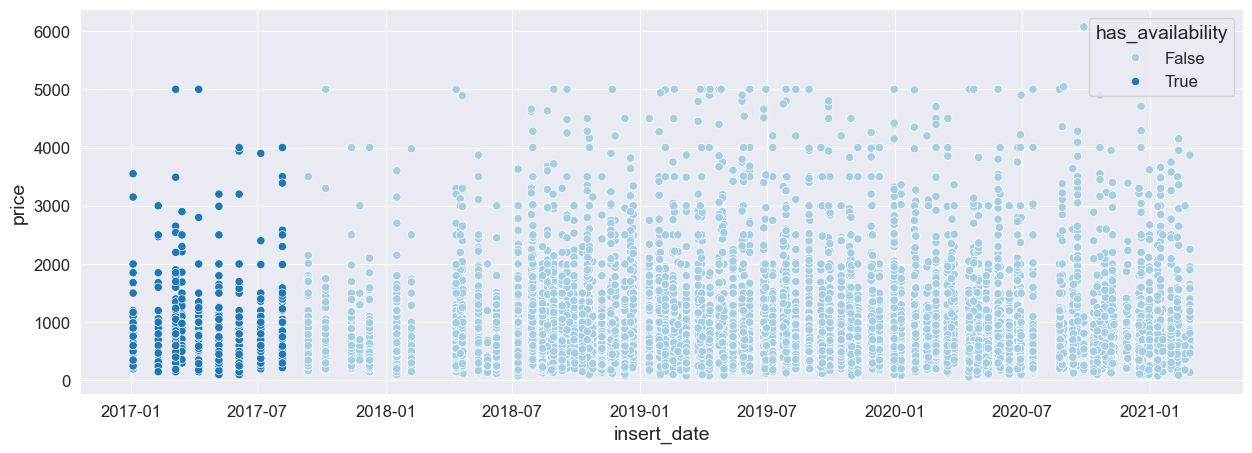

In [74]:
# distribution of has_availability values over time
plt.figure(figsize=(15,5))
sns.scatterplot(data=df_clean, x='insert_date', y='price', hue=df_clean['has_availability'].isna())
plt.show()

NaN values in `has_availability` may be due to this variable being introduced after August 2017. To simplify calculations, we can treat NaN values as 'False'.

In [76]:
# NaN -> "0", 'VERDADERO' -> "1"
df_clean['has_availability'] = np.where(df_clean['has_availability'] == 'VERDADERO', 1, 0)

df_clean['has_availability'].value_counts(dropna=False)

has_availability
1    7159
0     534
Name: count, dtype: int64

#### price
We have 121 objects without a `price`, we can **design an imputation strategy**, as price is a key value for our analysis and decision-making

First, lets investigate when we had objects with missing prices: let's see if the missing prices are more characteristic of specific days. Let's use `availability_30` to visualize this.

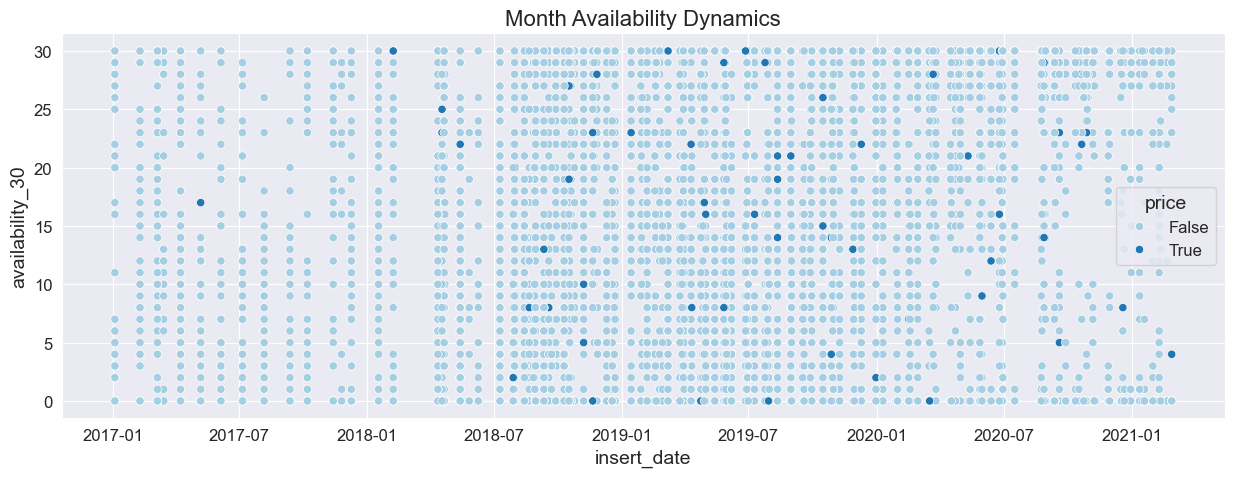

In [77]:
# availability_30 dynamics
plt.figure(figsize=(15,5))
sns.scatterplot(data=df_clean, x='insert_date', y='availability_30', hue=df_clean['price'].isna())
plt.title('Month Availability Dynamics')
plt.show()

In [78]:
print('Number of missing prices per day')
df_clean.query('price.isna()').insert_date.value_counts()

Number of missing prices per day


insert_date
2020-09-19    5
2020-05-28    5
2019-04-24    4
2018-11-07    4
2019-10-16    4
             ..
2017-08-06    1
2020-04-17    1
2018-01-17    1
2018-07-10    1
2019-07-30    1
Name: count, Length: 83, dtype: int64

Although some `insert_dates` have more than one missing price, there are no specific days with a large number of missing prices. Therefore, we can almost rule out a technical error.

Let's see if missing prices are caracteristic for specific values of different columns.

In [79]:
cols = ['host_id', 'city', 'neighbourhood_district', 'neighbourhood_name',
        'room_type', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'minimum_nights',
       'has_availability', 'availability_30',
       'availability_60', 'availability_90', 'availability_365',
       'number_of_reviews',
       'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'is_instant_bookable'
       ]

for col in cols:
    print()
    print(df_clean.query('price.isna()')[col].value_counts())


host_id
231620389    8
4459553      7
206349691    5
43337979     3
173328477    3
            ..
91420568     1
87345986     1
85168184     1
81843163     1
241455572    1
Name: count, Length: 126, dtype: int64

city
mallorca     73
barcelona    34
madrid       22
girona       17
menorca       6
sevilla       3
valencia      3
malaga        1
Name: count, dtype: int64

neighbourhood_district
Eixample                 17
Centro                   12
Sant Mart�                7
Casco Antiguo             3
Ciutat Vella              3
Usera                     3
Gr�cia                    3
CIUTAT VELLA              2
Sants-Montju�c            2
Sarri�-Sant Gervasi       2
Salamanca                 2
Latina                    2
Retiro                    1
San Blas - Canillejas     1
RASCANYA                  1
Chamber�                  1
Name: count, dtype: int64

neighbourhood_name
Pollen�a                         10
Palma de Mallorca                 9
la Dreta de l'Eixample            9
A

We can see that the prices are mostly missing for large and probably expensive whole apartments/houses, in half of the cases - in Mallorca. As a rule, they have high ratings, but in a large number of cases there are no reviews. Also, there is one host who has 7 missing prices, let's check them.

In [80]:
# host with 7 missing prices
df_clean.query('host_id==4459553')['city'].value_counts()

city
barcelona    28
Name: count, dtype: int64

In [81]:
df_clean.query('host_id==4459553')

,apartment_id,name,description,host_id,neighbourhood_name,neighbourhood_district,room_type,accommodates,bathrooms,bedrooms,beds,amenities_list,price,minimum_nights,maximum_nights,has_availability,availability_30,availability_60,availability_90,availability_365,number_of_reviews,first_review_date,last_review_date,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,is_instant_bookable,reviews_per_month,country,city,insert_date
743,3107710,1563 - AB Pla�a Espanya 2-1 - Classy 3-Bedroom...,This modish three bedroom holiday apartment in...,4459553,la Nova Esquerra de l'Eixample,Eixample,Entire home/apt,6,2,3,6.00,"TV,Internet,Wifi,Air conditioning,Kitchen,Elev...",NaN,2,330,1,9,34,64,339,11,2016-06-20,2018-08-20,800.00,80.00,90.00,80.00,80.00,90.00,80.00,1,38.00,spain,barcelona,2018-11-07
2759,13988785,1993 - AB Pla�a Espanya XI - Stylish 3-Bedroom...,This lovely apartment is situated in the centr...,4459553,la Nova Esquerra de l'Eixample,Eixample,Entire home/apt,6,1,3,6.00,"TV,Internet,Wifi,Air conditioning,Kitchen,Smok...",3500.00,3,330,1,0,0,0,69,18,2018-01-01,2019-08-17,790.00,80.00,90.00,80.00,90.00,90.00,80.00,1,8.00,spain,barcelona,2019-11-09
3033,15066661,1908 - AB Vila i Vil� Apartment 4-1 - Lovely A...,"This is a comfortable apartment in Barcelona, ...",4459553,el Poble Sec,Sants-Montju�c,Entire home/apt,6,1,3,6.00,"TV,Internet,Wifi,Air conditioning,Kitchen,Smok...",4000.00,2,330,1,13,14,40,315,34,2017-03-25,2019-11-11,800.00,80.00,80.00,80.00,80.00,90.00,80.00,1,103.00,spain,barcelona,2019-12-10
3096,15262802,1554 - AB Passeig de Gr�cia Pelai - Modern Cit...,"This spacious apartment in Barcelona, recently...",4459553,el Raval,Ciutat Vella,Entire home/apt,7,1,2,5.00,"TV,Internet,Wifi,Air conditioning,Kitchen,Elev...",NaN,3,330,1,10,23,50,306,29,2016-12-29,2018-11-19,860.00,90.00,90.00,80.00,90.00,100.00,90.00,1,122.00,spain,barcelona,2018-12-10
3196,15712249,327 - AB Central Villarroel - Trendy City Cent...,This charming two-bedroom apartment in Barcelo...,4459553,Sant Antoni,Eixample,Entire home/apt,5,1,2,3.00,"TV,Internet,Wifi,Air conditioning,Kitchen,Pets...",3500.00,3,330,1,6,17,29,304,15,2018-05-10,2019-06-17,830.00,80.00,80.00,90.00,100.00,90.00,90.00,1,105.00,spain,barcelona,2019-07-10
3847,17726001,2427 - AB Plaza Catalunya Luxury Apartment 3-4,"This luxurious, two bedroom apartment is perfe...",4459553,la Dreta de l'Eixample,Eixample,Entire home/apt,6,2,2,2.00,"TV,Wireless Internet,Air conditioning,Kitchen,...",NaN,3,1125,0,2,16,45,135,4,2017-03-27,2017-07-22,1000.00,100.00,100.00,100.00,100.00,100.00,90.00,1,9.00,spain,barcelona,2017-08-06
3849,17726179,2428 - AB Pla�a Catalunya 1-2 - Modern Apartme...,"This sleek, modern four-bedroom apartment is t...",4459553,la Dreta de l'Eixample,Eixample,Entire home/apt,10,2,3,7.00,"TV,Internet,Wifi,Air conditioning,Wheelchair a...",NaN,3,330,1,5,24,51,317,12,2017-07-25,2018-06-30,820.00,90.00,90.00,90.00,90.00,100.00,80.00,1,76.00,spain,barcelona,2018-11-07
3869,17755675,2292 - AB Arag� Apartment 1-C - Modern Apartme...,"This chic and stylish apartment, in a recently...",4459553,l'Antiga Esquerra de l'Eixample,Eixample,Entire home/apt,6,2,2,5.00,"TV,Internet,Wifi,Air conditioning,Kitchen,Smok...",5000.00,2,330,1,3,33,61,330,15,2017-07-25,2019-03-11,870.00,90.00,90.00,90.00,90.00,90.00,80.00,1,72.00,spain,barcelona,2019-04-10
3874,17757695,2294 - AB Arag� Apartment 2-C - Central Apartm...,"This superb apartment, in a recently renovated...",4459553,l'Antiga Esquerra de l'Eixample,Eixample,Entire home/apt,6,2,2,5.00,"TV,Internet,Wifi,Air conditioning,Kitchen,Smok...",5000.00,2,330,1,27,57,87,362,18,2017-09-09,2019-03-25,810.00,90.00,90.00,90.00,90.00,90.00,80.00,1,93.00,spain,barcelona,2019-04-10
3914,17835432,2296 - AB Arag� Apartment 3-C - Stylish Apartm...,You�ll find this exceptionally-located apartme...,4459553,l'Antiga Esquerra de l'Eixample,Eixample,Entire hom

We can see that some objects do not have prices, while similar ones do. We can assume that these are similar objects and we could later use their prices to fill in NaNs.

#### Handling Missing Prices

At the moment, we can used KNNImputer algorithm to find similar prices based on the characteristics of each accommodation, 
averaging the 5 most similar ones.

In [82]:
missing_before_imputation = df_clean['price'].isna().sum()
print("missing before imputation : ", missing_before_imputation)

missing before imputation :  159


In [83]:
# Seleccionar columnas relevantes para la imputación
features = ['accommodates', 'bedrooms', 'beds', 'bathrooms', 'review_scores_rating',
            'availability_30', 'availability_60', 'availability_90', 'availability_365', 'price']

# solo columnas numéricas
df_impute = df_clean[features].copy()

# Normalizar datos antes de usar KNNImputer
scaler = StandardScaler()
df_impute_scaled = scaler.fit_transform(df_impute)

# Crear e implementar el imputador KNN
imputer = KNNImputer(n_neighbors=5)  #  los 5 vecinos más cercanos
df_imputed_scaled = imputer.fit_transform(df_impute_scaled)

# Desescalar la columna 'price' de vuelta a su rango original
df_clean['price'] = scaler.inverse_transform(df_imputed_scaled)[:, -1]

In [84]:
# Verificar si quedan valores faltantes
missing_after_imputation = df_clean['price'].isna().sum()
print("missing after imputation : ", missing_after_imputation)

missing after imputation :  0


#### Reviews

In [86]:
df_no_reviews = df[df['number_of_reviews'] == 0]

# Count NaN values in the relevant columns for rows where number_of_reviews == 0
nan_count = df_no_reviews[['first_review_date', 'last_review_date', 'review_scores_rating', 
                           'review_scores_accuracy', 'review_scores_cleanliness', 
                           'review_scores_checkin', 'review_scores_communication', 
                           'review_scores_location', 'review_scores_value']].isna().sum()

print("NaN Count in each column for rows with number_of_reviews == 0:")
print(nan_count)

NaN Count in each column for rows with number_of_reviews == 0:
first_review_date              1611
last_review_date               1611
review_scores_rating           1611
review_scores_accuracy         1611
review_scores_cleanliness      1611
review_scores_checkin          1611
review_scores_communication    1611
review_scores_location         1611
review_scores_value            1611
dtype: int64


In [87]:
# Check unique values for each column
unique_values = df_no_reviews[['first_review_date', 'last_review_date', 'review_scores_rating', 
                               'review_scores_accuracy', 'review_scores_cleanliness', 
                               'review_scores_checkin', 'review_scores_communication', 
                               'review_scores_location', 'review_scores_value']].nunique()

print("\nUnique Values count for each column for rows with number_of_reviews == 0:")
print(unique_values)



Unique Values count for each column for rows with number_of_reviews == 0:
first_review_date              0
last_review_date               0
review_scores_rating           0
review_scores_accuracy         0
review_scores_cleanliness      0
review_scores_checkin          0
review_scores_communication    0
review_scores_location         0
review_scores_value            0
dtype: int64


#### Indicator for Presence of Reviews in Accommodations

For the rows where `'number_of_reviews' == 0`, all the review-related data is missing (i.e., `NaN`). This suggests that the accommodation has no reviews.

Thus, the column `'number_of_reviews'` can be used as an indicator for the **presence or absence of reviews** for a given accommodation. If `'number_of_reviews' == 0`, this indicates that there are no reviews for that accommodation, and we can consider the review-related fields as absent.

We can use this insight to handle missing values or filter data based on the presence or absence of reviews.


In [88]:
# Filter rows where 'number_of_reviews' is not equal to 0
df_yes_reviews = df[df['number_of_reviews'] != 0]

# Count NaN values in the relevant columns for rows where 'number_of_reviews' != 0
nan_count = df_yes_reviews[['first_review_date', 'last_review_date', 'review_scores_rating', 
                            'review_scores_accuracy', 'review_scores_cleanliness', 
                            'review_scores_checkin', 'review_scores_communication', 
                            'review_scores_location', 'review_scores_value']].isna().sum()

print("NaN Count in each column for rows with number_of_reviews != 0:")
print(nan_count)

NaN Count in each column for rows with number_of_reviews != 0:
first_review_date                3
last_review_date                 4
review_scores_rating            85
review_scores_accuracy          94
review_scores_cleanliness       88
review_scores_checkin           99
review_scores_communication     90
review_scores_location         100
review_scores_value            100
dtype: int64


In [89]:
# Filter rows where any of the selected columns have NaN values
df_with_nan = df_yes_reviews[df_yes_reviews[['first_review_date', 'last_review_date', 'review_scores_rating', 
                                              'review_scores_accuracy', 'review_scores_cleanliness', 
                                              'review_scores_checkin', 'review_scores_communication', 
                                              'review_scores_location', 'review_scores_value']].isna().any(axis=1)]

# Print the rows with NaN values
df_with_nan
#df_with_nan.to_csv(f'../Data/data_missed_review_scores.csv', index=False)

,apartment_id,name,description,host_id,neighbourhood_name,neighbourhood_district,room_type,accommodates,bathrooms,bedrooms,beds,amenities_list,price,minimum_nights,maximum_nights,has_availability,availability_30,availability_60,availability_90,availability_365,number_of_reviews,first_review_date,last_review_date,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,is_instant_bookable,reviews_per_month,country,city,insert_date
596,2368293,MAISON AU CALME AVEC PISCINE,Photos et description de la location a EMPURIA...,12100602,Castell� d'Emp�ries,None,Entire home/apt,6,1,2,3.00,"TV,Cable TV,Wifi,Air conditioning,Pool,Kitchen...",1270.00,2,30,VERDADERO,0,0,0,0,2,2017-04-12,2017-05-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,9.00,spain,girona,2019-02-19
734,3073348,"APARTAMENTOS AQUARIUM. 25 M2 TERRAZA, BARBACOA","Apartamento con 1 habitaci�n doble, comedor co...",14040896,Roses,None,Entire home/apt,4,1,1,4.00,"TV,Kitchen,Smoking allowed,Pets allowed,Free s...",520.00,3,30,VERDADERO,26,48,78,325,1,2014-07-15,2014-07-15,200.00,NaN,100.00,20.00,80.00,NaN,40.00,0,2.00,spain,girona,2018-11-26
1045,4847335,"Chalet independiente, muy tranquilo","Ideal acceso a playas, naturaleza en zona, sen...",24830684,Santany�,None,Entire home/apt,8,3,4,6.00,"TV,Pool,Kitchen,Smoking allowed,Pets allowed,H...",1900.00,3,1125,VERDADERO,0,0,0,0,2,2015-04-28,2015-04-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,5.00,spain,mallorca,2018-07-29
1172,5486531,"Villa: TEOLUNA, Begur, Costa Brava",Beautiful house located in the urbanization re...,26281633,Begur,None,Entire home/apt,12,4,5,6.00,"TV,Pool,Kitchen,Free parking on premises,Heati...",2530.00,7,1125,VERDADERO,29,29,29,29,1,2017-07-22,2017-07-22,800.00,NaN,60.00,NaN,NaN,NaN,NaN,1,7.00,spain,girona,2018-09-28
1179,5542982,Estudio Avenida de America Madrid,"Estudio con capacidad 3 personas ,2 camas dobl...",8177214,Guindalera,Salamanca,Entire home/apt,2,1,0,2.00,"TV,Internet,Wifi,Wheelchair accessible,Kitchen...",350.00,15,350,VERDADERO,24,48,78,353,1,2019-01-21,2019-01-21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,37.00,spain,madrid,2019-04-11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7321,29018387,Apartamento 1� l�nea playa Puerto Alcudia CRB,Se trata de un apartamento en planta baja que ...,8864750,Alc�dia,None,Entire home/apt,4,1,2,3.00,"TV,Wifi,Air conditioning,Pool,Kitchen,Free par...",800.00,5,1125,VERDADERO,9,36,64,288,1,2019-07-02,2019-07-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,11.00,spain,mallorca,2020-03-22
7411,29506330,Habitaci�n c�moda y muy luminosa. Metro a 7 min,None,211570371,Comillas,Carabanchel,Private room,1,1,1,1.00,"TV,Wifi,Air conditioning,Kitchen,Smoking allow...",320.00,3,29,VERDADERO,0,0,7,97,1,2018-11-01,2018-11-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,12.00,spain,madrid,2019-07-10
7445,29644147,32 - Apartamento Sagrada Familia,Apartamento nuevo a estrenar cerca de Sagrada ...,22076771,el Camp de l'Arpa del Clot,Sant Mart�,Entire home/apt,4,1,3,3.00,"Refrigerator, Wifi, Host greets you, Patio or ...",550.00,31,1125,VERDADERO,0,0,0,138,1,2019-07-30,2019-07-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,6.00,spain,barcelona,2020-12-16
7539,30227908,1+1 rooms like private apartment in Pl Tetuan,Like a APARTMENT ideal for family of 4. 1 doub...,6426377,la Dreta de l'Eixample,Eixample,Private room,4,1,2,2.00,"TV,Cable TV,Internet,Wifi,Air conditioning,Whe...",500.00,4,1125,VERDADERO,5,5,5,7,1,2018-11-24,2018-11-24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,10.00,spain,barcelona,2018-12-10


#### Handling Missing Data for Reviews with `number_of_reviews` != 0

For the rows where `'number_of_reviews' != 0`, we can see that there are some missing (`NaN`) values in the review-related columns. These missing values need to be addressed as they represent gaps in the review data, even though the accommodation has reviews. 

Here is the count of missing values (`NaN`) for each of the relevant columns


In [90]:
df_with_nan['apartment_id'].value_counts().head(5)

apartment_id
19402970    2
6257970     2
20893685    1
23387130    1
23346158    1
Name: count, dtype: int64

In [91]:
df[df['apartment_id'] == 19402970]

,apartment_id,name,description,host_id,neighbourhood_name,neighbourhood_district,room_type,accommodates,bathrooms,bedrooms,beds,amenities_list,price,minimum_nights,maximum_nights,has_availability,availability_30,availability_60,availability_90,availability_365,number_of_reviews,first_review_date,last_review_date,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,is_instant_bookable,reviews_per_month,country,city,insert_date
4579,19402970,Villa Oliver,In kurzer Entfernung der sch�nsten Str�nde der...,2221389,Santany�,None,Entire home/apt,8,2,3,6.00,"TV,Wifi,Air conditioning,Pool,Kitchen,Free par...",2500.00,7,1125,VERDADERO,0,0,26,301,1,2019-03-30,2019-03-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,16.00,spain,mallorca,2019-09-28
4580,19402970,Villa Oliver,In kurzer Entfernung der sch�nsten Str�nde der...,2221389,Santany�,None,Entire home/apt,7,2,3,4.00,"TV,Wifi,Air conditioning,Pool,Kitchen,Free par...",2500.00,7,1125,VERDADERO,29,49,79,354,1,2019-03-30,2019-03-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,7.00,spain,mallorca,2020-06-25


In [92]:
df[df['apartment_id'] == 6257970]

,apartment_id,name,description,host_id,neighbourhood_name,neighbourhood_district,room_type,accommodates,bathrooms,bedrooms,beds,amenities_list,price,minimum_nights,maximum_nights,has_availability,availability_30,availability_60,availability_90,availability_365,number_of_reviews,first_review_date,last_review_date,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,is_instant_bookable,reviews_per_month,country,city,insert_date
1306,6257970,�tico con terraza privada,fant�stico �tico con terraza soleada en el cen...,32262478,l'Antiga Esquerra de l'Eixample,Eixample,Private room,2,1,1,1.00,"Essentials, Wifi, Kitchen, Elevator, TV, First...",700.00,1,1125,VERDADERO,0,0,0,0,1,2015-05-15,2015-05-15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1.00,spain,barcelona,2020-11-06
1307,6257970,�tico con terraza privada,fant�stico �tico con terraza soleada en el cen...,32262478,l'Antiga Esquerra de l'Eixample,Eixample,Private room,2,1,1,1.00,"TV,Internet,Wifi,Wheelchair accessible,Kitchen...",700.00,1,1125,VERDADERO,0,0,0,0,1,2015-05-15,2015-05-15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,2.00,spain,barcelona,2020-01-10


### Standardization

In string columns (`name`, `description`, `neighbourhood_name`, `neighbourhood_district`)  we have presence of � (replacement characters for Spanish accents: á, é, í, ó, ú, ñ).

In [93]:
# columns containing � 
for col in df.loc[:, df.dtypes == 'object'].columns:
    print(col, df[col].str.contains('�').sum())

name 1637
description 5479
neighbourhood_name 1751
neighbourhood_district 1124
room_type 0
bathrooms 0
bedrooms 0
amenities_list 948
has_availability 0
country 0
city 0


#### City and Neighbourhood Standardization

In [94]:
raw_text="""original_city,original_neighbourhood,standardized_city,standardized_neighbourhood,autonomous_community
malaga,Centro,Málaga,Centro,Andalucía
madrid,C�rmenes,Madrid,Los Cármenes,Comunidad de Madrid
sevilla,San Vicente,Sevilla,San Vicente,Andalucía
barcelona,"l'Antiga Esquerra de l'Eixample",Barcelona,"L'Antiga Esquerra de l'Eixample",Cataluña
girona,Quart,Girona,Quart,Cataluña
girona,Torroella de Fluvi�,Girona,Torroella de Fluvià,Cataluña
barcelona,"el Camp de l'Arpa del Clot",Barcelona,"El Camp de l'Arpa del Clot",Cataluña
barcelona,"la Dreta de l'Eixample",Barcelona,"La Dreta de l'Eixample",Cataluña
madrid,Embajadores,Madrid,Embajadores,Comunidad de Madrid
barcelona,"el Camp d'en Grassot i Gr�cia Nova",Barcelona,"El Camp d'en Grassot i Gràcia Nova",Cataluña
barcelona,"el Raval",Barcelona,"El Raval",Cataluña
barcelona,"el Fort Pienc",Barcelona,"El Fort Pienc",Cataluña
madrid,Palacio,Madrid,Palacio,Comunidad de Madrid
madrid,"Palomeras Bajas",Madrid,"Palomeras Bajas",Comunidad de Madrid
girona,"Lloret de Mar",Girona,"Lloret de Mar",Cataluña
valencia,"EL PILAR",Valencia,"El Pilar",Comunidad Valenciana
barcelona,"Vallvidrera, el Tibidabo i les Planes",Barcelona,"Vallvidrera, el Tibidabo i les Planes",Cataluña
barcelona,Sants,Barcelona,Sants,Cataluña
barcelona,"Sant Antoni",Barcelona,"Sant Antoni",Cataluña
girona,Forallac,Girona,Forallac,Cataluña
barcelona,"les Corts",Barcelona,"Les Corts",Cataluña
mallorca,"Palma de Mallorca",Palma,"Palma de Mallorca",Islas Baleares
madrid,Universidad,Madrid,Universidad,Comunidad de Madrid
mallorca,Alc�dia,Palma,Alcúdia,Islas Baleares
madrid,Justicia,Madrid,Justicia,Comunidad de Madrid
barcelona,Horta,Barcelona,Horta,Cataluña
barcelona,"Sant Pere, Santa Caterina i la Ribera",Barcelona,"Sant Pere, Santa Caterina i la Ribera",Cataluña
barcelona,"el Poble Sec",Barcelona,"El Poble Sec",Cataluña
valencia,"EN CORTS",Valencia,"En Corts",Comunidad Valenciana
girona,Capmany,Girona,Capmany,Cataluña
madrid,Aluche,Madrid,Aluche,Comunidad de Madrid
girona,"Castell� d'Emp�ries",Girona,"Castelló d'Empúries",Cataluña
barcelona,"Can Peguera",Barcelona,"Can Peguera",Cataluña
madrid,Cortes,Madrid,Cortes,Comunidad de Madrid
madrid,"Ciudad Jard�n",Madrid,"Ciudad Jardín",Comunidad de Madrid
barcelona,"la Vila de Gr�cia",Barcelona,"La Vila de Gràcia",Cataluña
barcelona,"la Nova Esquerra de l'Eixample",Barcelona,"La Nova Esquerra de l'Eixample",Cataluña
madrid,"Ni�o Jes�s",Madrid,"Niño Jesús",Comunidad de Madrid
madrid,Sol,Madrid,Sol,Comunidad de Madrid
valencia,RUSSAFA,Valencia,Russafa,Comunidad Valenciana
barcelona,"Vilapicina i la Torre Llobeta",Barcelona,"Vilapicina i la Torre Llobeta",Cataluña
sevilla,Arenal,Sevilla,Arenal,Andalucía
girona,Begur,Girona,Begur,Cataluña
mallorca,Selva,Palma,Selva,Islas Baleares
sevilla,Alfalfa,Sevilla,Alfalfa,Andalucía
barcelona,"la Sagrada Fam�lia",Barcelona,"La Sagrada Família",Cataluña
mallorca,"Santa Margalida",Palma,"Santa Margalida",Islas Baleares
valencia,"EL CARME",Valencia,"El Carme",Comunidad Valenciana
girona,"Tossa de Mar",Girona,"Tossa de Mar",Cataluña
barcelona,"el Putxet i el Farr�",Barcelona,"El Putxet i el Farró",Cataluña
barcelona,"el Barri G�tic",Barcelona,"El Barri Gòtic",Cataluña
menorca,"Es Mercadal",Menorca,"Es Mercadal",Islas Baleares
barcelona,"el Poblenou",Barcelona,"El Poblenou",Cataluña
mallorca,Campos,Palma,Campos,Islas Baleares
mallorca,S�ller,Palma,Sóller,Islas Baleares
menorca,"Ciutadella de Menorca",Menorca,Ciutadella,Islas Baleares
mallorca,Valldemossa,Palma,Valldemossa,Islas Baleares
barcelona,"la Font de la Guatlla",Barcelona,"La Font de la Guatlla",Cataluña
sevilla,"Los Remedios",Sevilla,"Los Remedios",Andalucía
mallorca,Santany�,Palma,Santanyí,Islas Baleares
barcelona,"la Vila Ol�mpica del Poblenou",Barcelona,"La Vila Olímpica del Poblenou",Cataluña
barcelona,"el Coll",Barcelona,"El Coll",Cataluña
madrid,"San Ferm�n",Madrid,"San Fermín",Comunidad de Madrid
madrid,Comillas,Madrid,Comillas,Comunidad de Madrid
madrid,Prosperidad,Madrid,Prosperidad,Comunidad de Madrid
madrid,Acacias,Madrid,Acacias,Comunidad de Madrid
mallorca,Llub�,Palma,Llubí,Islas Baleares
girona,Roses,Girona,Roses,Cataluña
valencia,"LA SEU",Valencia,"La Seu",Comunidad Valenciana
barcelona,"el Parc i la Llacuna del Poblenou",Barcelona,"El Parc i la Llacuna del Poblenou",Cataluña
madrid,"Cuatro Caminos",Madrid,"Cuatro Caminos",Comunidad de Madrid
sevilla,"San Juli�n",Sevilla,"San Julián",Andalucía
girona,Palafrugell,Girona,Palafrugell,Cataluña
barcelona,"la Prosperitat",Barcelona,"La Prosperitat",Cataluña
barcelona,"el Clot",Barcelona,"El Clot",Cataluña
barcelona,"les Tres Torres",Barcelona,"Les Tres Torres",Cataluña
madrid,"Pinar del Rey",Madrid,"Pinar del Rey",Comunidad de Madrid
barcelona,"Vallcarca i els Penitents",Barcelona,"Vallcarca i els Penitents",Cataluña
madrid,"Los Angeles",Madrid,"Los Ángeles",Comunidad de Madrid
sevilla,"San Bartolom�",Sevilla,"San Bartolomé",Andalucía
mallorca,Inca,Palma,Inca,Islas Baleares
sevilla,"Tabladilla, La Estrella",Sevilla,"Tabladilla, La Estrella",Andalucía
menorca,Alaior,Menorca,Alaior,Islas Baleares
mallorca,Calvi�,Palma,Calvià,Islas Baleares
malaga,"Cruz De Humilladero",Málaga,"Cruz de Humilladero",Andalucía
malaga,Este,Málaga,Este,Andalucía
mallorca,Costitx,Palma,Costitx,Islas Baleares
sevilla,"an Roque",Sevilla,"San Roque",Andalucía
sevilla,"Santa Cruz",Sevilla,"Santa Cruz",Andalucía
girona,"Sant Climent Sescebes",Girona,"Sant Climent Sescebes",Cataluña
valencia,ARRANCAPINS,Valencia,Arrancapins,Comunidad Valenciana
madrid,Portazgo,Madrid,Portazgo,Comunidad de Madrid
madrid,"Palos de Moguer",Madrid,"Palos de Moguer",Comunidad de Madrid
mallorca,Pollen�a,Palma,Pollença,Islas Baleares
madrid,Recoletos,Madrid,Recoletos,Comunidad de Madrid
madrid,Castilla,Madrid,Castilla,Comunidad de Madrid
madrid,Legazpi,Madrid,Legazpi,Comunidad de Madrid
sevilla,Feria,Sevilla,Feria,Andalucía
sevilla,"San Lorenzo",Sevilla,"San Lorenzo",Andalucía
girona,Girona,Girona,Girona,Cataluña
mallorca,"Ses Salines",Palma,"Ses Salines",Islas Baleares
barcelona,"la Salut",Barcelona,"La Salut",Cataluña
sevilla,Museo,Sevilla,Museo,Andalucía
sevilla,"Encarnaci�n, Regina",Sevilla,"Encarnación, Regina",Andalucía
girona,Cadaqu�s,Girona,Cadaqués,Cataluña
mallorca,Manacor,Palma,Manacor,Islas Baleares
menorca,Mah�n,Menorca,Mahón,Islas Baleares
mallorca,Felanitx,Palma,Felanitx,Islas Baleares
girona,"L'Escala",Girona,"L'Escala",Cataluña
barcelona,"la Barceloneta",Barcelona,"La Barceloneta",Cataluña
valencia,"LA ROQUETA",Valencia,"La Roqueta",Comunidad Valenciana
mallorca,Puigpunyent,Palma,Puigpunyent,Islas Baleares
mallorca,Lloseta,Palma,Lloseta,Islas Baleares
barcelona,Sarri�,Barcelona,Sarrià,Cataluña
mallorca,Petra,Palma,Petra,Islas Baleares
girona,Palam�s,Girona,Palamós,Cataluña
malaga,"Carretera de Cadiz",Málaga,"Carretera de Cádiz",Andalucía
madrid,"Ciudad Universitaria",Madrid,"Ciudad Universitaria",Comunidad de Madrid
girona,Celr�,Girona,Celrà,Cataluña
mallorca,Llucmajor,Palma,Llucmajor,Islas Baleares
mallorca,Algaida,Palma,Algaida,Islas Baleares
madrid,Valdeacederas,Madrid,Valdeacederas,Comunidad de Madrid
girona,"Castell-Platja d'Aro",Girona,"Castell-Platja d'Aro",Cataluña
sevilla,"San Bernardo",Sevilla,"San Bernardo",Andalucía
girona,Cabanelles,Girona,Cabanelles,Cataluña
girona,"Torroella de Montgr�",Girona,"Torroella de Montgrí",Cataluña
barcelona,"Can Bar�",Barcelona,"Can Baró",Cataluña
barcelona,"Sant Gervasi - la Bonanova",Barcelona,"Sant Gervasi - la Bonanova",Cataluña
madrid,Arg�elles,Madrid,Argüelles,Comunidad de Madrid
sevilla,"Triana Casco Antiguo",Sevilla,"Triana Casco Antiguo",Andalucía
mallorca,Campanet,Palma,Campanet,Islas Baleares
madrid,Trafalgar,Madrid,Trafalgar,Comunidad de Madrid
mallorca,Fornalutx,Palma,Fornalutx,Islas Baleares
girona,"La Selva de Mar",Girona,"La Selva de Mar",Cataluña
girona,Llan��,Girona,Llançà,Cataluña
valencia,MORVEDRE,Valencia,Morvedre,Comunidad Valenciana
madrid,Pac�fico,Madrid,Pacífico,Comunidad de Madrid
barcelona,"Proven�als del Poblenou",Barcelona,"Provençals del Poblenou",Cataluña
barcelona,"Sants - Badal",Barcelona,"Sants-Badal",Cataluña
barcelona,"el Carmel",Barcelona,"El Carmel",Cataluña
valencia,"PENYA-ROJA",Valencia,"Penya-Roja",Comunidad Valenciana
mallorca,Marratx�,Palma,Marratxí,Islas Baleares
madrid,"Vista Alegre",Madrid,"Vista Alegre",Comunidad de Madrid
valencia,"LA CARRASCA",Valencia,"La Carrasca",Comunidad Valenciana
girona,"Sant Feliu de Gu�xols",Girona,"Sant Feliu de Guíxols",Cataluña
barcelona,"Diagonal Mar i el Front Mar�tim del Poblenou",Barcelona,"Diagonal Mar i el Front Marítim del Poblenou",Cataluña
sevilla,"San Gil",Sevilla,"San Gil",Andalucía
barcelona,"Sant Gervasi - Galvany",Barcelona,"Sant Gervasi - Galvany",Cataluña
madrid,"El Viso",Madrid,"El Viso",Comunidad de Madrid
barcelona,"la Marina del Prat Vermell",Barcelona,"La Marina del Prat Vermell",Cataluña
valencia,"EL CALVARI",Valencia,"El Calvario",Comunidad Valenciana
madrid,Goya,Madrid,Goya,Comunidad de Madrid
barcelona,"la Bordeta",Barcelona,"La Bordeta",Cataluña
malaga,"Palma-Palmilla",Málaga,"Palma-Palmilla",Andalucía
madrid,Atocha,Madrid,Atocha,Comunidad de Madrid
girona,Blanes,Girona,Blanes,Cataluña
mallorca,"Santa Mar�a del Cam�",Palma,"Santa María del Camí",Islas Baleares
mallorca,Escorca,Palma,Escorca,Islas Baleares
madrid,Almenara,Madrid,Almenara,Comunidad de Madrid
girona,Pont�s,Girona,Pontós,Cataluña
sevilla,"Le�n XIII, Los Naranjos",Sevilla,"León XIII, Los Naranjos",Andalucía
mallorca,"Sant Lloren� des Cardassar",Palma,"Sant Llorenç des Cardassar",Islas Baleares
menorca,"Sant Llu�s",Menorca,"Sant Lluís",Islas Baleares
madrid,Lista,Madrid,Lista,Comunidad de Madrid
sevilla,"San Pablo A y B",Sevilla,"San Pablo",Andalucía
girona,"La Vall de Bianya",Girona,"La Vall de Bianya",Cataluña
barcelona,"la Marina de Port",Barcelona,"La Marina de Port",Cataluña
barcelona,Pedralbes,Barcelona,Pedralbes,Cataluña
malaga,Churriana,Málaga,Churriana,Andalucía
barcelona,"Sant Gen�s dels Agudells",Barcelona,"Sant Genís dels Agudells",Cataluña
mallorca,Art�,Palma,Artà,Islas Baleares
girona,Ripoll,Girona,Ripoll,Cataluña
barcelona,"el Baix Guinard�",Barcelona,"El Baix Guinardó",Cataluña
girona,Albons,Girona,Albons,Cataluña
girona,Calonge,Girona,Calonge,Cataluña
girona,Tortell�,Girona,Tortellà,Cataluña
girona,Ordis,Girona,Ordis,Cataluña
mallorca,Muro,Palma,Muro,Islas Baleares
mallorca,Alar�,Palma,Alaró,Islas Baleares
mallorca,"Son Servera",Palma,"Son Servera",Islas Baleares
barcelona,"la Maternitat i Sant Ramon",Barcelona,"La Maternitat i Sant Ramon",Cataluña
madrid,"Rios Rosas",Madrid,"Ríos Rosas",Comunidad de Madrid
mallorca,"Lloret de Vistalegre",Palma,"Lloret de Vistalegre",Islas Baleares
valencia,"LA GRAN VIA",Valencia,"La Gran Vía",Comunidad Valenciana
mallorca,Capdepera,Palma,Capdepera,Islas Baleares
madrid,"Hispanoam�rica",Madrid,"Hispanoamérica",Comunidad de Madrid
girona,"Cornell� del Terri",Girona,"Cornellà del Terri",Cataluña
mallorca,Esporles,Palma,Esporles,Islas Baleares
sevilla,"Pedro Salvador, Las Palmeritas",Sevilla,"Pedro Salvador, Las Palmeritas",Andalucía
valencia,AIORA,Valencia,Aiora,Comunidad Valenciana
mallorca,B�ger,Palma,Búger,Islas Baleares
girona,Llad�,Girona,Lladó,Cataluña
girona,"Palau de Santa Eul�lia",Girona,"Palau de Santa Eulàlia",Cataluña
sevilla,"Giralda Sur",Sevilla,"Giralda Sur",Andalucía
barcelona,"la Verneda i la Pau",Barcelona,"La Verneda i la Pau",Cataluña
madrid,Delicias,Madrid,Delicias,Comunidad de Madrid
malaga,"Teatinos-Universidad",Málaga,"Teatinos-Universidad",Andalucía
girona,Vilademuls,Girona,Vilademuls,Cataluña
girona,Figueres,Girona,Figueres,Cataluña
sevilla,"Ciudad Jard�n",Sevilla,"Ciudad Jardín",Andalucía
girona,Pals,Girona,Pals,Cataluña
barcelona,"el Congr�s i els Indians",Barcelona,"El Congrés i els Indians",Cataluña
madrid,Castillejos,Madrid,Castillejos,Comunidad de Madrid
barcelona,"el Bes�s i el Maresme",Barcelona,"El Besòs i el Maresme",Cataluña
madrid,Almagro,Madrid,Almagro,Comunidad de Madrid
madrid,Imperial,Madrid,Imperial,Comunidad de Madrid
valencia,MESTALLA,Valencia,Mestalla,Comunidad Valenciana
valencia,"EL PLA DEL REMEI",Valencia,"El Pla del Remei",Comunidad Valenciana
madrid,Castellana,Madrid,Castellana,Comunidad de Madrid
valencia,"EL MERCAT",Valencia,"El Mercat",Comunidad Valenciana
madrid,Ibiza,Madrid,Ibiza,Comunidad de Madrid
valencia,"LA MALVA-ROSA",Valencia,"La Malva-Rosa",Comunidad Valenciana
mallorca,Dey�,Palma,Deià,Islas Baleares
madrid,Simancas,Madrid,Simancas,Comunidad de Madrid
barcelona,Montbau,Barcelona,Montbau,Cataluña
mallorca,Binissalem,Palma,Binissalem,Islas Baleares
madrid,"Casco Hist�rico de Vallecas",Madrid,Vallecas,Comunidad de Madrid
valencia,"LA XEREA",Valencia,"La Xerea",Comunidad Valenciana
valencia,CAMPANAR,Valencia,Campanar,Comunidad Valenciana
girona,Alp,Girona,Alp,Cataluña
sevilla,"Cruz Roja, Capuchinos",Sevilla,"Cruz Roja, Capuchinos",Andalucía
madrid,Ventas,Madrid,Ventas,Comunidad de Madrid
sevilla,"Carretera de Carmona, Mar�a Auxiliadora, Fontanal",Sevilla,"Carretera de Carmona, María Auxiliadora, Fontanal",Andalucía
valencia,"SANT FRANCESC",Valencia,"Sant Francesc",Comunidad Valenciana
barcelona,Hostafrancs,Barcelona,Hostafrancs,Cataluña
barcelona,"la Vall d'Hebron",Barcelona,"La Vall d'Hebron",Cataluña
valencia,"LA RAIOSA",Valencia,"La Raiosa",Comunidad Valenciana
madrid,"Pueblo Nuevo",Madrid,"Pueblo Nuevo",Comunidad de Madrid
sevilla,"Palacio Congresos, Urbadiez, Entrepuentes, Jardines del Eden",Sevilla,"Palacio de Congresos, Urbadiez, Entrepuentes, Jardines del Eden",Andalucía
girona,"Palau-sator",Girona,"Palau-sator",Cataluña
girona,Fontanilles,Girona,Fontanilles,Cataluña
mallorca,"Sa Pobla",Palma,"Sa Pobla",Islas Baleares
madrid,Abrantes,Madrid,Abrantes,Comunidad de Madrid
madrid,Gaztambide,Madrid,Gaztambide,Comunidad de Madrid
girona,Ur�s,Girona,Urús,Cataluña
girona,Llers,Girona,Llers,Cataluña
girona,"Sant Mori",Girona,"Sant Mori",Cataluña
girona,Madremanya,Girona,Madremanya,Cataluña
barcelona,Navas,Barcelona,Navas,Cataluña
girona,Pardines,Girona,Pardines,Cataluña
girona,"Sant Mart� Vell",Girona,"Sant Martí Vell",Cataluña
madrid,"San Diego",Madrid,"San Diego",Comunidad de Madrid
madrid,Guindalera,Madrid,Guindalera,Comunidad de Madrid
girona,Vila�r,Girona,Vilaür,Cataluña
girona,Vidr�,Girona,Vidré,Cataluña
madrid,"San Pascual",Madrid,"San Pascual",Comunidad de Madrid
mallorca,"Maria de la Salut",Palma,"Maria de la Salut",Islas Baleares
valencia,"CIUTAT UNIVERSITARIA",Valencia,"Ciutat Universitària",Comunidad Valenciana
valencia,"MONT-OLIVET",Valencia,"Mont-Olivet",Comunidad Valenciana
valencia,"SANT ANTONI",Valencia,"Sant Antoni",Comunidad Valenciana
barcelona,"Sant Mart� de Proven�als",Barcelona,"Sant Martí de Provençals",Cataluña
girona,"Sant Jordi Desvalls",Girona,"Sant Jordi Desvalls",Cataluña
girona,"Sant Feliu de Buixalleu",Girona,"Sant Feliu de Buixalleu",Cataluña
barcelona,"el Guinard�",Barcelona,"El Guinardó",Cataluña
madrid,Valdefuentes,Madrid,Valdefuentes,Comunidad de Madrid
madrid,Concepci�n,Madrid,Concepción,Comunidad de Madrid
valencia,"EL BOTANIC",Valencia,"El Botànic",Comunidad Valenciana
sevilla,"La Buhaira",Sevilla,"La Buhaira",Andalucía
girona,Bescan�,Girona,Bescanó,Cataluña
madrid,Jer�nimos,Madrid,Jerónimos,Comunidad de Madrid
sevilla,"Triana Este",Sevilla,"Triana Este",Andalucía
madrid,"Casa de Campo",Madrid,"Casa de Campo",Comunidad de Madrid
barcelona,"Ciutat Meridiana",Barcelona,"Ciutat Meridiana",Cataluña
barcelona,"la Teixonera",Barcelona,"La Teixonera",Cataluña
madrid,Numancia,Madrid,Numancia,Comunidad de Madrid
girona,Masarac,Girona,Masarac,Cataluña
girona,Vidreres,Girona,Vidreres,Cataluña
girona,"Sant Ferriol",Girona,"Sant Ferriol",Cataluña
girona,"Ribes de Freser",Girona,"Ribes de Freser",Cataluña
madrid,Moscard�,Madrid,Moscardó,Comunidad de Madrid
mallorca,Consell,Palma,Consell,Islas Baleares
valencia,BENIMACLET,Valencia,Benimaclet,Comunidad Valenciana
girona,Vilabertran,Girona,Vilabertran,Cataluña
valencia,"CABANYAL-CANYAMELAR",Valencia,"Cabanyal-Canyamelar",Comunidad Valenciana
madrid,Vallehermoso,Madrid,Vallehermoso,Comunidad de Madrid
madrid,Vinateros,Madrid,Vinateros,Comunidad de Madrid
sevilla,"Doctor Barraquer, G. Renfe, Policl�nico",Sevilla,"Doctor Barraquer, G. Renfe, Policlínico",Andalucía
girona,Campelles,Girona,Campelles,Cataluña
madrid,Canillas,Madrid,Canillas,Comunidad de Madrid
madrid,"Puerta del Angel",Madrid,"Puerta del Ángel",Comunidad de Madrid
mallorca,Andratx,Palma,Andratx,Islas Baleares
barcelona,Verdun,Barcelona,Verdun,Cataluña
girona,"El Port de la Selva",Girona,"El Port de la Selva",Cataluña
girona,"Santa Cristina d'Aro",Girona,"Santa Cristina d'Aro",Cataluña
girona,Seriny�,Girona,Serinyà,Cataluña
girona,Banyoles,Girona,Banyoles,Cataluña
malaga,"Bailen-Miraflores",Málaga,"Bailén-Miraflores",Andalucía
girona,"Cru�lles, Monells i Sant Sadurn� de l'Heura",Girona,"Cru�lles, Monells i Sant Sadurní de l'Heura",Cataluña
girona,"Montagut i Oix",Girona,"Montagut i Oix",Cataluña
mallorca,Montu�ri,Palma,Montuïri,Islas Baleares
girona,Olot,Girona,Olot,Cataluña
barcelona,"el Tur� de la Peira",Barcelona,"El Turó de la Peira",Cataluña
sevilla,"Santa Catalina",Sevilla,"Santa Catalina",Andalucía
barcelona,"la Guineueta",Barcelona,"La Guineueta",Cataluña
girona,Ventall�,Girona,Ventalló,Cataluña
madrid,Arapiles,Madrid,Arapiles,Comunidad de Madrid
barcelona,Porta,Barcelona,Porta,Cataluña
madrid,Palomas,Madrid,Palomas,Comunidad de Madrid
mallorca,"Mancor de la Vall",Palma,"Mancor de la Vall",Islas Baleares
madrid,Fontarr�n,Madrid,Fontarrón,Comunidad de Madrid
girona,Camprodon,Girona,Camprodon,Cataluña
sevilla,"Colores, Entreparques",Sevilla,"Colores, Entreparques",Andalucía
madrid,Chopera,Madrid,Chopera,Comunidad de Madrid
sevilla,"Pio XII",Sevilla,"Pío XII",Andalucía
valencia,MARXALENES,Valencia,Marxalenes,Comunidad Valenciana
madrid,Campamento,Madrid,Campamento,Comunidad de Madrid
madrid,Pilar,Madrid,Pilar,Comunidad de Madrid
valencia,"CIUTAT JARDI",Valencia,"Ciutat Jardí",Comunidad Valenciana
mallorca,Sineu,Palma,Sineu,Islas Baleares
sevilla,"La Florida",Sevilla,"La Florida",Andalucía
madrid,Quintana,Madrid,Quintana,Comunidad de Madrid
madrid,"San Andr�s",Madrid,"San Andrés",Comunidad de Madrid
madrid,"Alameda de Osuna",Madrid,"Alameda de Osuna",Comunidad de Madrid
girona,"La Bisbal d'Emporda",Girona,"La Bisbal d'Empordà",Cataluña
girona,Peralada,Girona,Peralada,Cataluña
madrid,Valdezarza,Madrid,Valdezarza,Comunidad de Madrid
barcelona,"el Bon Pastor",Barcelona,"El Bon Pastor",Cataluña
sevilla,"Huerta de la Salud",Sevilla,"Huerta de la Salud",Andalucía
mallorca,Sencelles,Palma,Sencelles,Islas Baleares
madrid,"Fuente del Berro",Madrid,"Fuente del Berro",Comunidad de Madrid
sevilla,"El Roc�o",Sevilla,"El Rocío",Andalucía
sevilla,"Triana Oeste",Sevilla,"Triana Oeste",Andalucía
madrid,"Puerta Bonita",Madrid,"Puerta Bonita",Comunidad de Madrid
mallorca,Ariany,Palma,Ariany,Islas Baleares
madrid,Berruguete,Madrid,Berruguete,Comunidad de Madrid
valencia,"ELS ORRIOLS",Valencia,"Els Orriols",Comunidad Valenciana
valencia,PATRAIX,Valencia,Patraix,Comunidad Valenciana
madrid,Adelfas,Madrid,Adelfas,Comunidad de Madrid
madrid,"San Juan Bautista",Madrid,"San Juan Bautista",Comunidad de Madrid
madrid,Piovera,Madrid,Piovera,Comunidad de Madrid
girona,"Sant Pere Pescador",Girona,"Sant Pere Pescador",Cataluña
valencia,"NOU MOLES",Valencia,"Nou Moles",Comunidad Valenciana
girona,Sils,Girona,Sils,Cataluña
girona,Amer,Girona,Amer,Cataluña
madrid,"La Paz",Madrid,"La Paz",Comunidad de Madrid
girona,"Bellcaire d'Empord�",Girona,"Bellcaire d'Empordà",Cataluña
madrid,"Bellas Vistas",Madrid,"Bellas Vistas",Comunidad de Madrid
sevilla,Nervi�n,Sevilla,Nervión,Andalucía
menorca,"Es Castell",Menorca,"Es Castell",Islas Baleares
madrid,"Palomeras Sureste",Madrid,"Palomeras Sureste",Comunidad de Madrid
mallorca,"Santa Eug�nia",Palma,"Santa Eugènia",Islas Baleares
sevilla,"El Carmen",Sevilla,"El Carmen",Andalucía
mallorca,Bunyola,Palma,Bunyola,Islas Baleares
valencia,"EL PERELLONET",Valencia,"El Perellonet",Comunidad Valenciana
malaga,"Ciudad Jardin",Málaga,"Ciudad Jardín",Andalucía
madrid,Almendrales,Madrid,Almendrales,Comunidad de Madrid
valencia,FAVARA,Valencia,Favara,Comunidad Valenciana
madrid,Buenavista,Madrid,Buenavista,Comunidad de Madrid
mallorca,Banyalbufar,Palma,Banyalbufar,Islas Baleares
girona,Aiguaviva,Girona,Aiguaviva,Cataluña
girona,Besal�,Girona,Besalú,Cataluña
madrid,"Nueva Espa�a",Madrid,"Nueva España",Comunidad de Madrid
girona,Jafre,Girona,Jafre,Cataluña
mallorca,"Vilafranc de Bonany",Palma,"Vilafranca de Bonany",Islas Baleares
madrid,Costillares,Madrid,Costillares,Comunidad de Madrid
girona,"L'Armentera",Girona,"L'Armentera",Cataluña
girona,Ull�,Girona,Ullà,Cataluña
valencia,"VARA DE QUART",Valencia,"Vara de Quart",Comunidad Valenciana
madrid,Valverde,Madrid,Valverde,Comunidad de Madrid
valencia,BENICALAP,Valencia,Benicalap,Comunidad Valenciana
madrid,Mirasierra,Madrid,Mirasierra,Comunidad de Madrid
girona,"Sales de Llierca",Girona,"Sales de Llierca",Cataluña
girona,Saus,Girona,Saus,Cataluña
madrid,Pe�agrande,Madrid,Peñagrande,Comunidad de Madrid
girona,Osor,Girona,Osor,Cataluña
madrid,"Casco Hist�rico de Barajas",Madrid,Barajas,Comunidad de Madrid
barcelona,Vallbona,Barcelona,Vallbona,Cataluña
valencia,"SANT LLORENS",Valencia,"Sant Llorenç",Comunidad Valenciana
girona,Vilamaniscle,Girona,Vilamaniscle,Cataluña
sevilla,"San Jos� Obrero",Sevilla,"San José Obrero",Andalucía
sevilla,"La Palmilla, Doctor Mara��n",Sevilla,"La Palmilla, Doctor Marañón",Andalucía
madrid,Aguilas,Madrid,Águilas,Comunidad de Madrid
valencia,NATZARET,Valencia,Nazaret,Comunidad Valenciana
sevilla,"Barrio Le�n",Sevilla,"Barrio León",Andalucía
malaga,"Puerto de la Torre",Málaga,"Puerto de la Torre",Andalucía
girona,"Fontanals de Cerdanya",Girona,"Fontanals de Cerdanya",Cataluña
girona,"Riells i Viabrea",Girona,"Riells i Viabrea",Cataluña
barcelona,"la Sagrera",Barcelona,"La Sagrera",Cataluña
madrid,Butarque,Madrid,Butarque,Comunidad de Madrid
girona,Bolvir,Girona,Bolvir,Cataluña
barcelona,"Sant Andreu",Barcelona,"Sant Andreu",Cataluña
madrid,Canillejas,Madrid,Canillejas,Comunidad de Madrid
girona,"Les Llosses",Girona,"Les Llosses",Cataluña
girona,Puigcerd�,Girona,Puigcerdà,Cataluña
sevilla,"El Tard�n, El Carmen",Sevilla,"El Tardón, El Carmen",Andalucía
madrid,Hell�n,Madrid,Hellín,Comunidad de Madrid
girona,"Santa Pau",Girona,"Santa Pau",Cataluña
girona,"Sant Joan de les Abadesses",Girona,"Sant Joan de les Abadesses",Cataluña
valencia,"CIUTAT FALLERA",Valencia,"Ciutat Fallera",Comunidad Valenciana
madrid,Opa�el,Madrid,Opáñel,Comunidad de Madrid
girona,"Sant Mart� de Ll�mena",Girona,"Sant Martí de Llémena",Cataluña
valencia,"LA PETXINA",Valencia,"La Petxina",Comunidad Valenciana
valencia,FAITANAR,Valencia,Faitanar,Comunidad Valenciana
sevilla,"El Cerro",Sevilla,"El Cerro",Andalucía
barcelona,"la Font d'en Fargues",Barcelona,"La Font d'en Fargues",Cataluña
valencia,"L'HORT DE SENABRE",Valencia,"L'Hort de Senabre",Comunidad Valenciana
barcelona,"les Roquetes",Barcelona,"Les Roquetes",Cataluña
madrid,Arcos,Madrid,Arcos,Comunidad de Madrid
valencia,BENIMAMET,Valencia,Benimamet,Comunidad Valenciana
girona,Foix�,Girona,Foixà,Cataluña
madrid,"Casco Hist�rico de Vic�lvaro",Madrid,Vicálvaro,Comunidad de Madrid
madrid,Lucero,Madrid,Lucero,Comunidad de Madrid
girona,Ger,Girona,Ger,Cataluña
girona,Cantallops,Girona,Cantallops,Cataluña
girona,Navata,Girona,Navata,Cataluña
girona,"La Tallada d'Empord�",Girona,"La Tallada d'Empordà",Cataluña
girona,Colera,Girona,Colera,Cataluña
mallorca,Porreres,Palma,Porreres,Islas Baleares
madrid,Rejas,Madrid,Rejas,Comunidad de Madrid
girona,"Vallfogona de Ripoll�s",Girona,"Vallfogona de Ripollès",Cataluña
girona,Verges,Girona,Verges,Cataluña
girona,Campdev�nol,Girona,Campdevànol,Cataluña
girona,Rab�s,Girona,Rabós,Cataluña
mallorca,"Sant Joan",Palma,"Sant Joan",Islas Baleares
girona,"Palau-saverdera",Girona,"Palau-saverdera",Cataluña
girona,Regenc�s,Girona,Regencós,Cataluña
girona,Torrent,Girona,Torrent,Cataluña
valencia,"SANT PAU",Valencia,"Sant Pau",Comunidad Valenciana
madrid,Orcasitas,Madrid,Orcasitas,Comunidad de Madrid
sevilla,"no asignado",Sevilla,"No asignado",Andalucía
madrid,Zof�o,Madrid,Zofío,Comunidad de Madrid
girona,"Les Planes d'Hostoles",Girona,"Les Planes d'Hostoles",Cataluña
girona,"Sant Pau de Seg�ries",Girona,"Sant Pau de Segúries",Cataluña
girona,"Sant Andreu Salou",Girona,"Sant Andreu Salou",Cataluña
valencia,"CIUTAT DE LES ARTS I DE LES CIENCIES",Valencia,"Ciutat de les Arts i les Ciències",Comunidad Valenciana
barcelona,"Torre Bar�",Barcelona,"Torre Baró",Cataluña
sevilla,"Tiro de L�nea, Santa Genoveva",Sevilla,"Tiro de Línea, Santa Genoveva",Andalucía
madrid,Tim�n,Madrid,Timón,Comunidad de Madrid
valencia,TORMOS,Valencia,Tormos,Comunidad Valenciana
girona,"Sant Feliu de Pallerols",Girona,"Sant Feliu de Pallerols",Cataluña
valencia,TORREFIEL,Valencia,Torrefiel,Comunidad Valenciana
madrid,"San Isidro",Madrid,"San Isidro",Comunidad de Madrid
madrid,Estrella,Madrid,Estrella,Comunidad de Madrid
girona,Ma�anet de la Selva,Girona,Maçanet de la Selva,Cataluña
valencia,"LES TENDETES",Valencia,"Les Tendetes",Comunidad Valenciana
girona,Setcases,Girona,Setcases,Cataluña
barcelona,"la Trinitat Vella",Barcelona,"La Trinitat Vella",Cataluña
madrid,Entrev�as,Madrid,Entrevías,Comunidad de Madrid
sevilla,"El Porvenir",Sevilla,"El Porvenir",Andalucía
girona,Riudarenes,Girona,Riudarenes,Cataluña
valencia,"CAMI FONDO",Valencia,"Cami Fondo",Comunidad Valenciana
valencia,EXPOSICIO,Valencia,Exposició,Comunidad Valenciana
madrid,Aeropuerto,Madrid,Aeropuerto,Comunidad de Madrid
girona,Ultramort,Girona,Ultramort,Cataluña
sevilla,"Bda. de Pineda",Sevilla,"Barriada de Pineda",Andalucía
valencia,"NA ROVELLA",Valencia,"Na Robella",Comunidad Valenciana
sevilla,"Sector Sur, La Palmera, Reina Mercedes",Sevilla,"Sector Sur, La Palmera, Reina Mercedes",Andalucía
valencia,BETERO,Valencia,Beteró,Comunidad Valenciana
sevilla,"La Calzada",Sevilla,"La Calzada",Andalucía
valencia,TRINITAT,Valencia,Trinitat,Comunidad Valenciana
valencia,ALBORS,Valencia,Albors,Comunidad Valenciana
valencia,MASSARROJOS,Valencia,Massarrojos,Comunidad Valenciana
girona,"Mont-ras",Girona,"Mont-ras",Cataluña
valencia,"TRES FORQUES",Valencia,"Tres Forques",Comunidad Valenciana
valencia,"EL GRAU",Valencia,"El Grau",Comunidad Valenciana
girona,Terrades,Girona,Terrades,Cataluña
girona,Llagostera,Girona,Llagostera,Cataluña
sevilla,"La Bachillera",Sevilla,"La Bachillera",Andalucía
girona,"Vall-llobrega",Girona,"Vall-llobrega",Cataluña
madrid,"Media Legua",Madrid,"Media Legua",Comunidad de Madrid
girona,Cistella,Girona,Cistella,Cataluña
sevilla,Palmete,Sevilla,Palmete,Andalucía
girona,Planoles,Girona,Planoles,Cataluña
valencia,"EL SALER",Valencia,"El Saler",Comunidad Valenciana
madrid,Colina,Madrid,Colina,Comunidad de Madrid
menorca,Ferreries,Menorca,Ferreries,Islas Baleares
sevilla,"Bda. Pino Montano",Sevilla,"Barriada Pino Montano",Andalucía
valencia,SOTERNES,Valencia,Soternes,Comunidad Valenciana
girona,Espolla,Girona,Espolla,Cataluña
madrid,"San Cristobal",Madrid,"San Cristóbal",Comunidad de Madrid
madrid,Rosas,Madrid,Rosas,Comunidad de Madrid
valencia,"L'AMISTAT",Valencia,"L'Amistat",Comunidad Valenciana
girona,Parlav�,Girona,Parlavà,Cataluña
barcelona,"la Trinitat Nova",Barcelona,"La Trinitat Nova",Cataluña
girona,"La Vall d'en Bas",Girona,"La Vall d'en Bas",Cataluña
girona,"Sant Juli� de Ramis",Girona,"Sant Julià de Ramis",Cataluña
valencia,"L'ILLA PERDUDA",Valencia,"L'Illa Perduda",Comunidad Valenciana
girona,"Mai� de Montcal",Girona,"Maià de Montcal",Cataluña
girona,"B�scara",Girona,"Bàscara",Cataluña
"""
with open(f'../Data/mapping_locations.csv', 'w', encoding='utf-8-sig') as file:
    file.write(raw_text)
print("done saved to info_mapping_locations.csv")

done saved to info_mapping_locations.csv


In [95]:
# 1. Load data with proper encoding and quote handling
try:
    cleaned_locations = pd.read_csv(
        r"../Data/mapping_locations.csv",  
        encoding='utf-8-sig',
        quotechar='"',
        dtype={'original_neighbourhood': str, 'original_city': str}
    )
    
#    df = pd.read_csv(
#        r"C:\Users\lasso\OneDrive\Documentos\01 Simulacro\ProjecteData\Equip_F\Data\data_sprint_1.csv",
#        encoding='utf-8-sig',
#        dtype={'neighbourhood_name': str, 'city': str}
#    )

except Exception as e:
    print(f"🚨 Error loading files: {str(e)}")
    exit()

In [96]:
cleaned_locations

,original_city,original_neighbourhood,standardized_city,standardized_neighbourhood,autonomous_community
0,malaga,Centro,Málaga,Centro,Andalucía
1,madrid,C�rmenes,Madrid,Los Cármenes,Comunidad de Madrid
2,sevilla,San Vicente,Sevilla,San Vicente,Andalucía
3,barcelona,l'Antiga Esquerra de l'Eixample,Barcelona,L'Antiga Esquerra de l'Eixample,Cataluña
4,girona,Quart,Girona,Quart,Cataluña
...,...,...,...,...,...
474,girona,La Vall d'en Bas,Girona,La Vall d'en Bas,Cataluña
475,girona,Sant Juli� de Ramis,Girona,Sant Julià de Ramis,Cataluña
476,valencia,L'ILLA PERDUDA,Valencia,L'Illa Perduda,Comunidad Valenciana
477,girona,Mai� de Montcal,Girona,Maià de Montcal,Cataluña


In [97]:
# 2. Pre-merge cleaning (handle nulls and whitespace)
df_clean['neighbourhood_name'] = df_clean['neighbourhood_name'].str.strip().fillna('')
cleaned_locations['original_neighbourhood'] = cleaned_locations['original_neighbourhood'].str.strip().fillna('')

# 3. Merge with validation
merged = pd.merge(
    df_clean,
    cleaned_locations,
    left_on=['city', 'neighbourhood_name'],
    right_on=['original_city', 'original_neighbourhood'],
    how='left',
    indicator=True
)

In [99]:
# 4. Analyze results
unmapped = merged[merged['_merge'] == 'left_only']
print(f"\nMapping Results:")
print(f"✅ Mapped: {len(merged) - len(unmapped)}/{len(df_clean)} ({round(100*(len(merged)-len(unmapped))/len(df_clean),1)}%)")
print(f"⚠️ Unmapped: {len(unmapped)}")

if not unmapped.empty:
    # Show top 10 unmapped patterns
    print("\nTop 10 unmapped patterns:")
    mismatch_samples = unmapped.groupby(['city', 'neighbourhood_name']).size().nlargest(10)
    print(mismatch_samples)
    
    # Save detailed report
    mismatch_report = unmapped[['city', 'neighbourhood_name']].drop_duplicates()
    #mismatch_report.to_csv(f'../Data/unmapped_analysis.csv', index=False)
    print("\nSaved detailed unmapped analysis to 'unmapped_analysis.csv'")


Mapping Results:
✅ Mapped: 7677/7693 (99.8%)
⚠️ Unmapped: 16

Top 10 unmapped patterns:
city      neighbourhood_name
madrid    Orcasur               2
valencia  LA CREU DEL GRAU      2
girona    Arb�cies              1
          Palol de Revardit     1
          Queralbs              1
          Vilaju�ga             1
madrid    Los Rosales           1
          Salvador              1
sevilla   Huerta del Pilar      1
          La Oliva              1
dtype: int64

Saved detailed unmapped analysis to 'unmapped_analysis.csv'


In [101]:
# 5. Final output
initial_columns = list(df_clean)
df_clean = merged.drop(columns=['_merge', 'original_city', 'original_neighbourhood'])

print("\nMerge completed. Columns in final dataframe:\n")
print(list(df_clean))
print(f'\nNew columns: {list(set(df_clean.columns) - set(initial_columns))}')


Merge completed. Columns in final dataframe:

['apartment_id', 'name', 'description', 'host_id', 'neighbourhood_name', 'neighbourhood_district', 'room_type', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'amenities_list', 'price', 'minimum_nights', 'maximum_nights', 'has_availability', 'availability_30', 'availability_60', 'availability_90', 'availability_365', 'number_of_reviews', 'first_review_date', 'last_review_date', 'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value', 'is_instant_bookable', 'reviews_per_month', 'country', 'city', 'insert_date', 'standardized_city', 'standardized_neighbourhood', 'autonomous_community']

New columns: ['autonomous_community', 'standardized_city', 'standardized_neighbourhood']


In [102]:
# columns containing � 
for col in df_clean.loc[:, df_clean.dtypes == 'object'].columns:
    print(col, df_clean[col].str.contains('�').sum())

name 1569
description 5269
neighbourhood_name 1681
neighbourhood_district 1083
room_type 0
bathrooms 0
bedrooms 0
amenities_list 902
country 0
city 0
standardized_city 0
standardized_neighbourhood 3
autonomous_community 0


## EDA

In [288]:
df_clean.drop(['apartment_id', 'host_id'], axis=1).describe().T

,count,mean,min,25%,50%,75%,max,std
accommodates,6733.00,4.35,1.00,2.00,4.00,6.00,29.00,2.63
bathrooms,6702.00,1.61,0.00,1.00,1.00,2.00,12.00,0.99
bedrooms,6704.00,1.97,0.00,1.00,2.00,3.00,16.00,1.30
beds,6730.00,3.01,0.00,1.00,2.00,4.00,30.00,2.34
price,6733.00,1032.52,60.00,460.00,750.00,1250.00,6071.00,864.33
minimum_nights,6733.00,4.42,1.00,1.00,2.00,4.00,365.00,10.78
maximum_nights,6733.00,756.98,1.00,62.00,1125.00,1125.00,1125.00,498.75
has_availability,6733.00,0.92,0.00,1.00,1.00,1.00,1.00,0.27
availability_30,6733.00,12.29,0.00,0.00,10.00,24.00,30.00,11.54
availability_60,6733.00,27.42,0.00,2.00,26.00,50.00,60.00,22.48


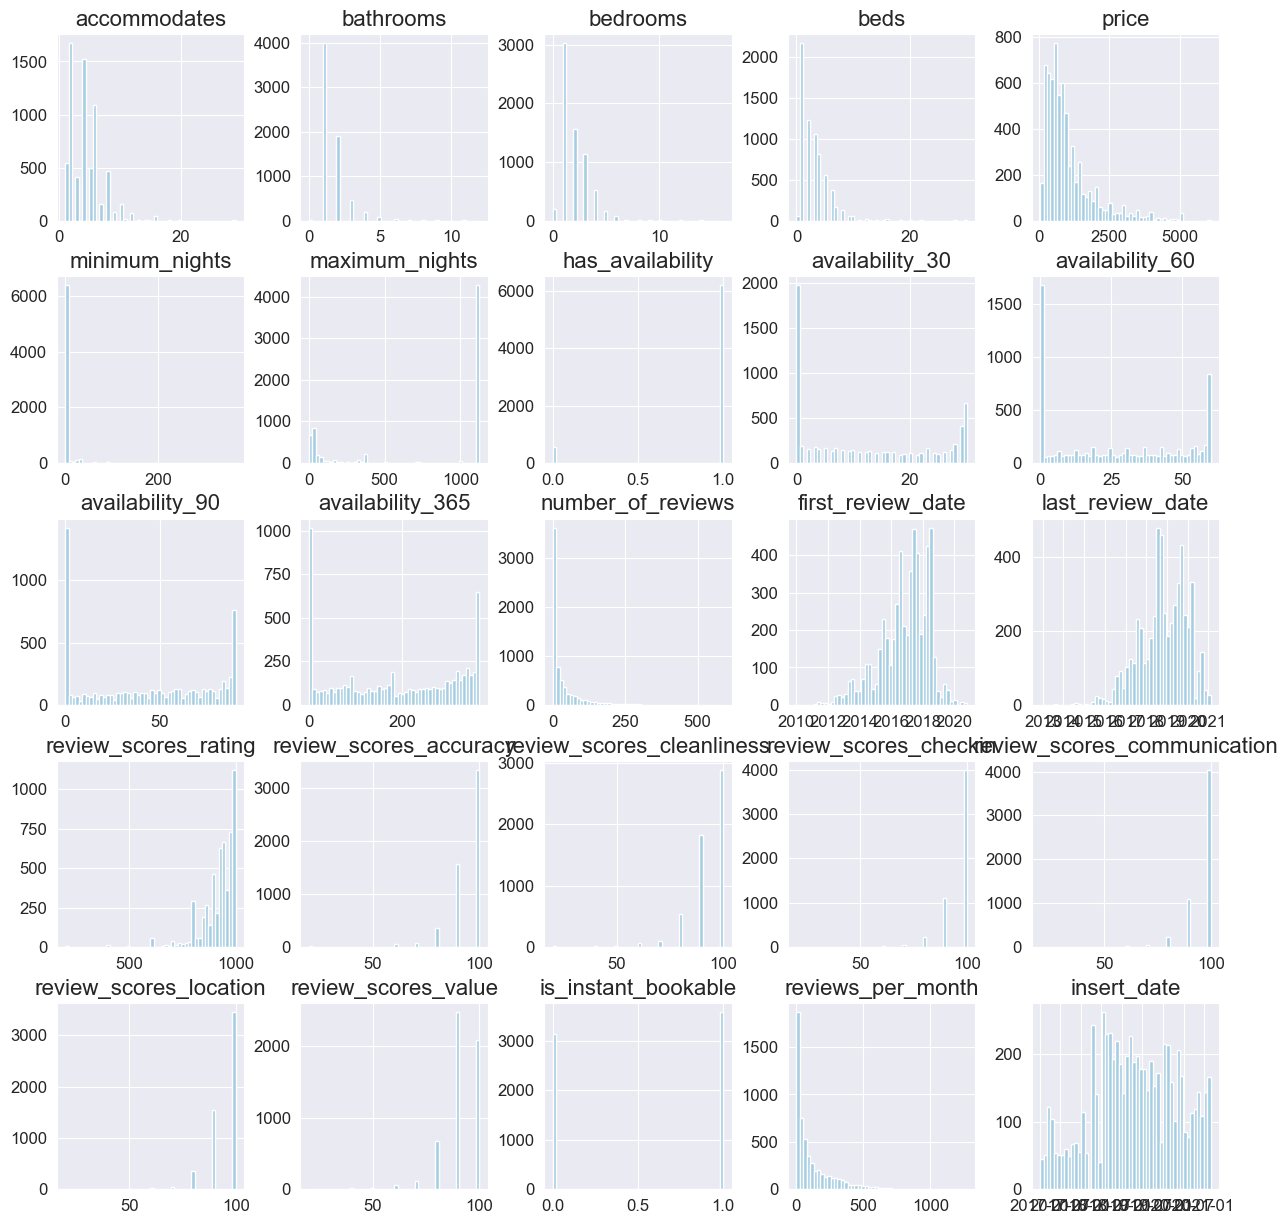

In [289]:
df_clean.drop(['apartment_id', 'host_id'], axis=1).hist(bins=50, figsize=(15,15))
plt.show()

### Categorical variables

In [290]:
df_clean.columns

Index(['apartment_id', 'name', 'description', 'host_id', 'neighbourhood_name',
       'neighbourhood_district', 'room_type', 'accommodates', 'bathrooms',
       'bedrooms', 'beds', 'amenities_list', 'price', 'minimum_nights',
       'maximum_nights', 'has_availability', 'availability_30',
       'availability_60', 'availability_90', 'availability_365',
       'number_of_reviews', 'first_review_date', 'last_review_date',
       'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'is_instant_bookable', 'reviews_per_month',
       'country', 'city', 'insert_date', 'standardized_city',
       'standardized_neighbourhood', 'autonomous_community'],
      dtype='object')

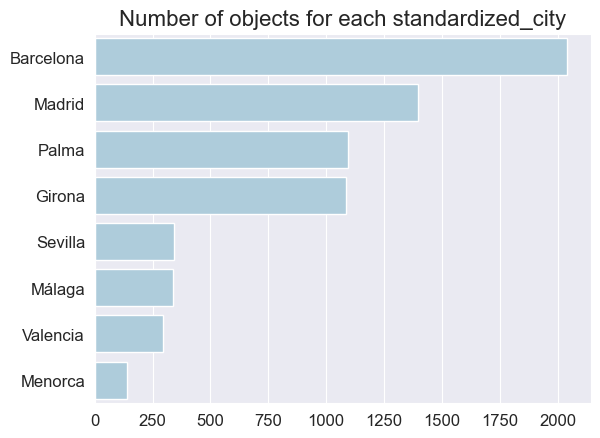

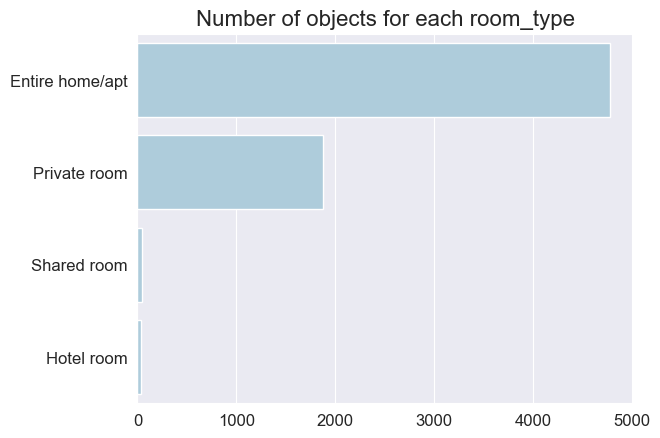

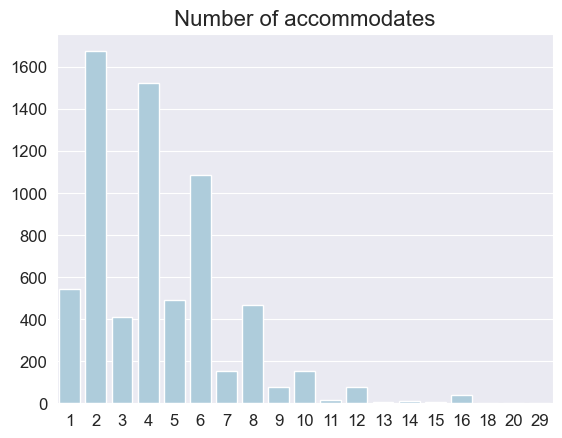

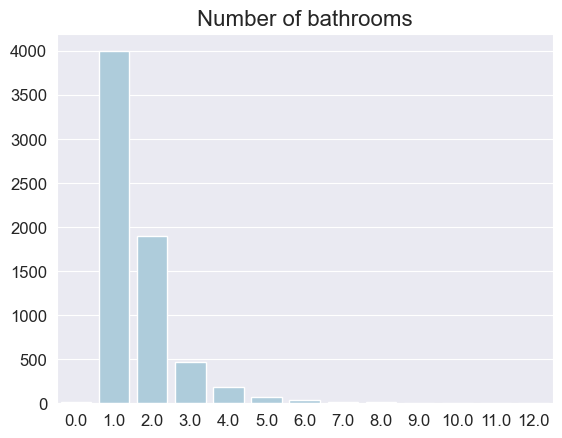

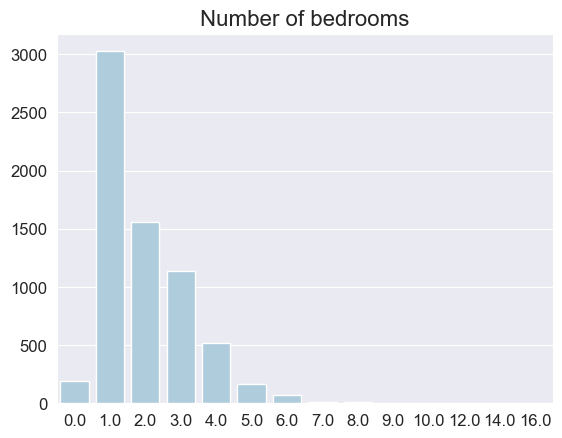

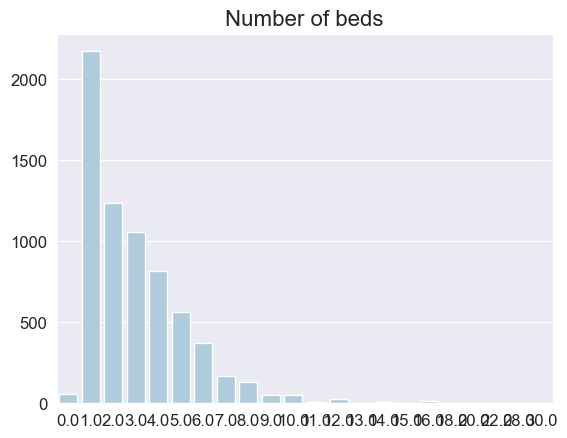

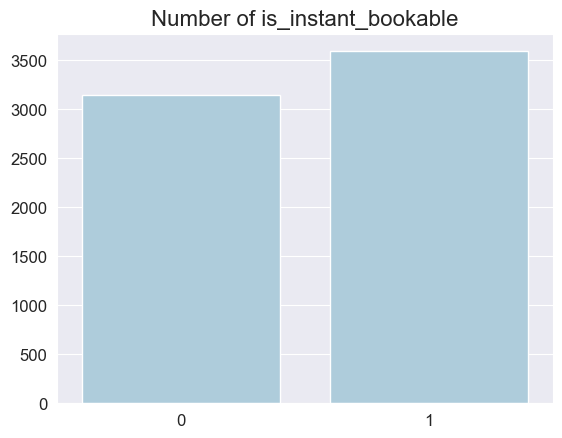

In [291]:
cat_cols = ['standardized_city', 'room_type', 'accommodates', 
            'bathrooms', 'bedrooms', 'beds',
            'is_instant_bookable']
            
for col in cat_cols:
    if col == 'standardized_city' or col == 'room_type':
        sns.countplot(data=df_clean, y=col, order=df_clean[col].value_counts().index)
        plt.title(f'Number of objects for each {col}')
    else:
        sns.countplot(data=df_clean, x=col)
        plt.title(f'Number of {col}')
    plt.xlabel(None)
    plt.ylabel(None)
    plt.show()

Let's check extreme values.

In [292]:
df_clean[df_clean.accommodates == 29]

,apartment_id,name,description,host_id,neighbourhood_name,neighbourhood_district,room_type,accommodates,bathrooms,bedrooms,beds,amenities_list,price,minimum_nights,maximum_nights,has_availability,availability_30,availability_60,availability_90,availability_365,number_of_reviews,first_review_date,last_review_date,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,is_instant_bookable,reviews_per_month,country,city,insert_date,standardized_city,standardized_neighbourhood,autonomous_community
3116,15883302,Ca's Misser,"Beautiful rustic farm with a total area of 21,...",102986764,Algaida,NaN,Entire home/apt,29,8.00,14.00,22.00,"TV,Cable TV,Internet,Wifi,Air conditioning,Poo...",3270.00,1,1125,1,5,19,27,218,3,2019-05-27,2019-09-18,800.00,80.00,90.00,90.00,60.00,90.00,70.00,1,32.00,spain,mallorca,2020-02-29,Palma,Algaida,Islas Baleares


In [293]:
df_clean[df_clean.beds == 30]

,apartment_id,name,description,host_id,neighbourhood_name,neighbourhood_district,room_type,accommodates,bathrooms,bedrooms,beds,amenities_list,price,minimum_nights,maximum_nights,has_availability,availability_30,availability_60,availability_90,availability_365,number_of_reviews,first_review_date,last_review_date,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,is_instant_bookable,reviews_per_month,country,city,insert_date,standardized_city,standardized_neighbourhood,autonomous_community
1118,5429715,Cal Pubill de Ciuret 35pax,Cal Pubill de Ciuret �s una de les grans masie...,20320423,Vidr�,NaN,Entire home/apt,16,9.00,14.00,30.00,"TV, Indoor fireplace, Pool, Iron, Crib, Hair d...",3486.00,2,1125,1,24,54,77,296,1,2019-12-08,2019-12-08,1000.00,100.00,100.00,100.00,100.00,100.00,100.00,1,9.00,spain,girona,2020-10-28,Girona,Vidré,Cataluña


In [294]:
df_clean[df_clean.bathrooms == 12]

,apartment_id,name,description,host_id,neighbourhood_name,neighbourhood_district,room_type,accommodates,bathrooms,bedrooms,beds,amenities_list,price,minimum_nights,maximum_nights,has_availability,availability_30,availability_60,availability_90,availability_365,number_of_reviews,first_review_date,last_review_date,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,is_instant_bookable,reviews_per_month,country,city,insert_date,standardized_city,standardized_neighbourhood,autonomous_community
1984,11196074,Finca can Domingo Es Trenc beach,"At the heart of the Balearic archipelago, sout...",16964951,Campos,NaN,Entire home/apt,16,12.00,10.00,16.00,"TV,Cable TV,Internet,Wifi,Air conditioning,Poo...",3442.00,3,1125,1,13,38,68,322,0,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,spain,mallorca,2019-11-28,Palma,Campos,Islas Baleares


In [295]:
df_clean[df_clean.bedrooms == 16]

,apartment_id,name,description,host_id,neighbourhood_name,neighbourhood_district,room_type,accommodates,bathrooms,bedrooms,beds,amenities_list,price,minimum_nights,maximum_nights,has_availability,availability_30,availability_60,availability_90,availability_365,number_of_reviews,first_review_date,last_review_date,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,is_instant_bookable,reviews_per_month,country,city,insert_date,standardized_city,standardized_neighbourhood,autonomous_community
4405,19412149,"Mallaui, a whole palace by the sea","Do you want to live in a Mediterranean villa, ...",136087677,Ciutadella de Menorca,NaN,Entire home/apt,16,7.00,16.00,28.00,"TV,Wifi,Kitchen,Free parking on premises,Smoki...",3524.00,4,30,1,9,10,10,85,4,2018-08-10,2019-07-09,1000.00,100.00,100.00,100.00,100.00,100.00,100.00,1,18.00,spain,menorca,2020-05-31,Menorca,Ciutadella,Islas Baleares


Data with "extreme" values looks normal.

### Numerical variables

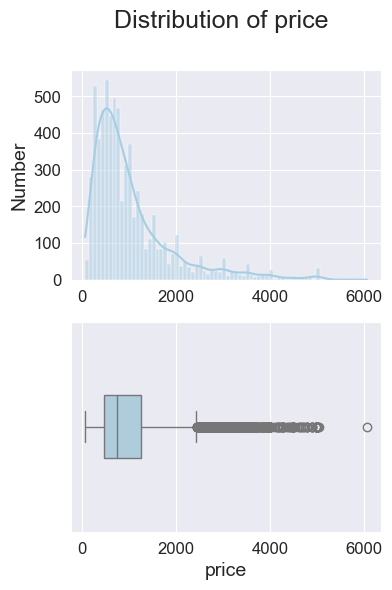

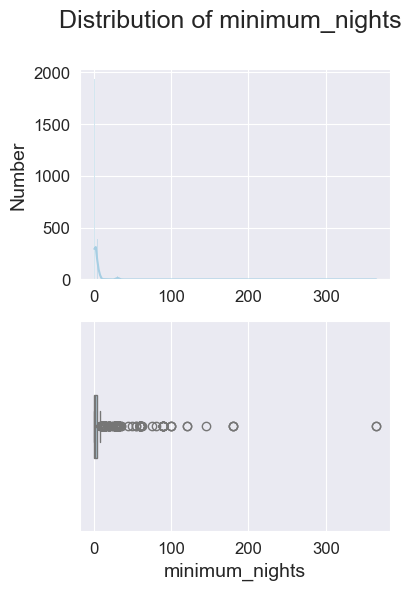

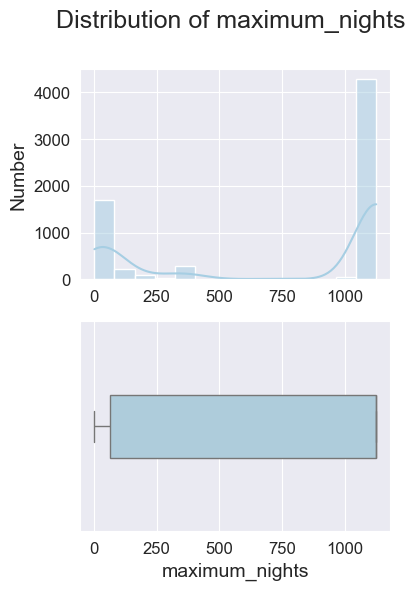

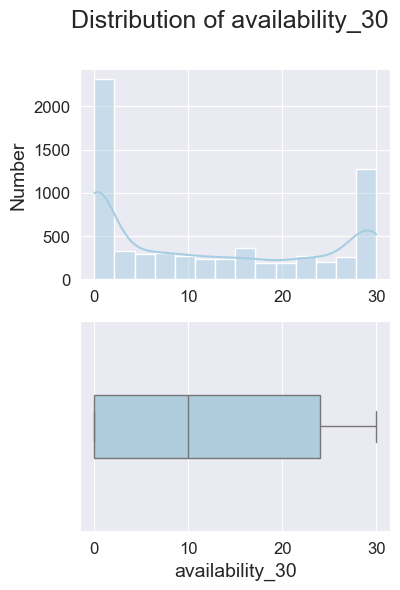

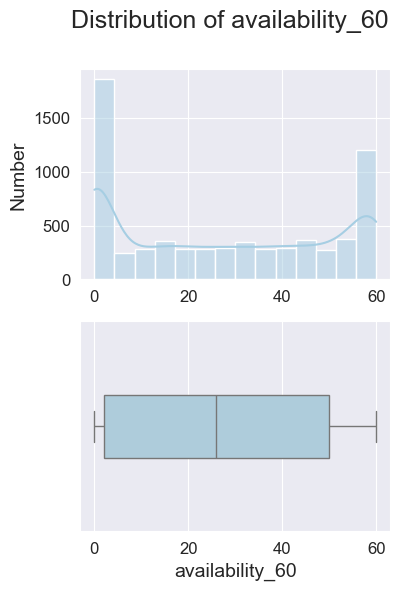

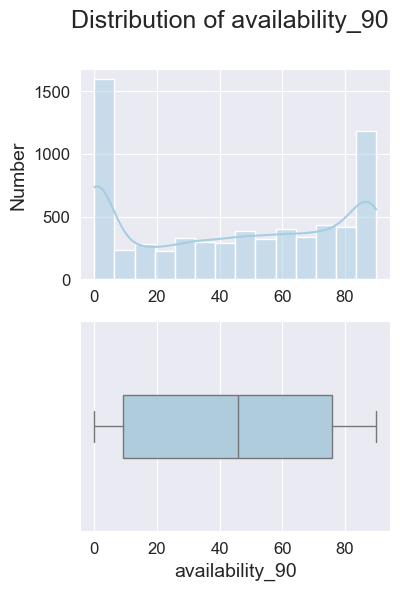

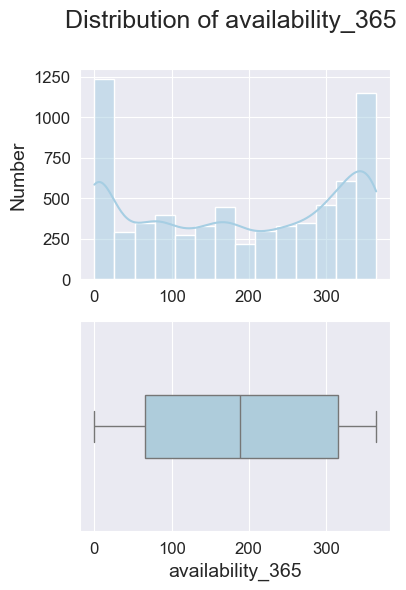

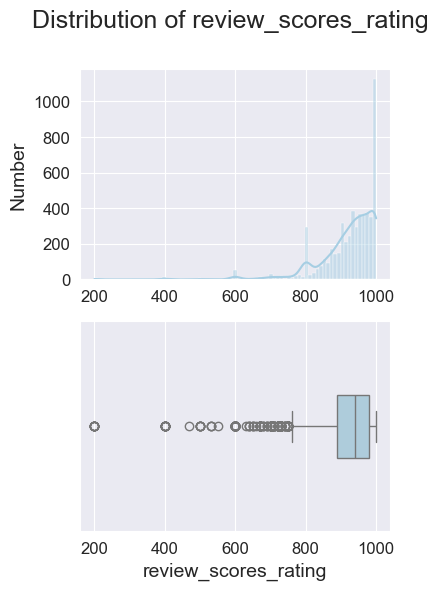

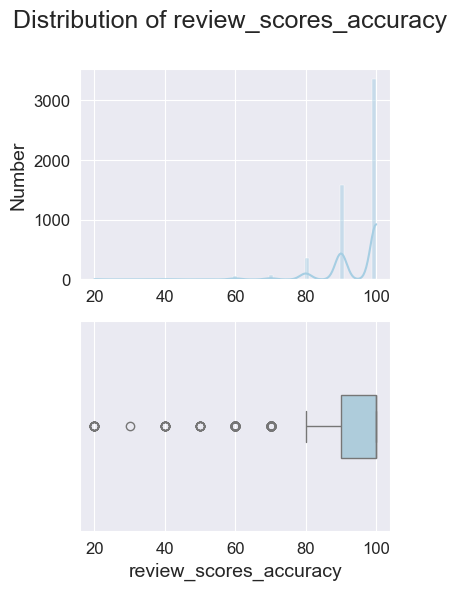

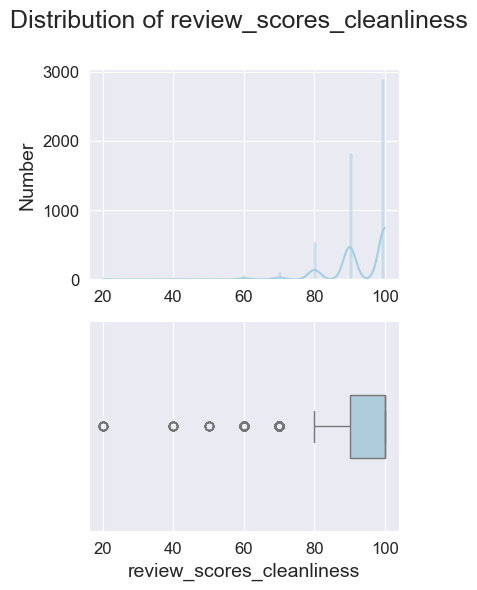

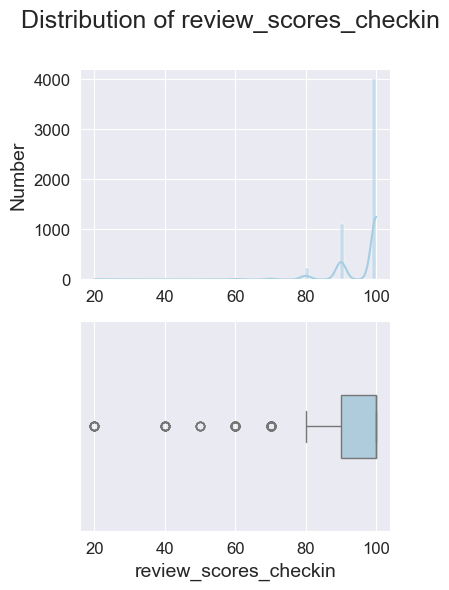

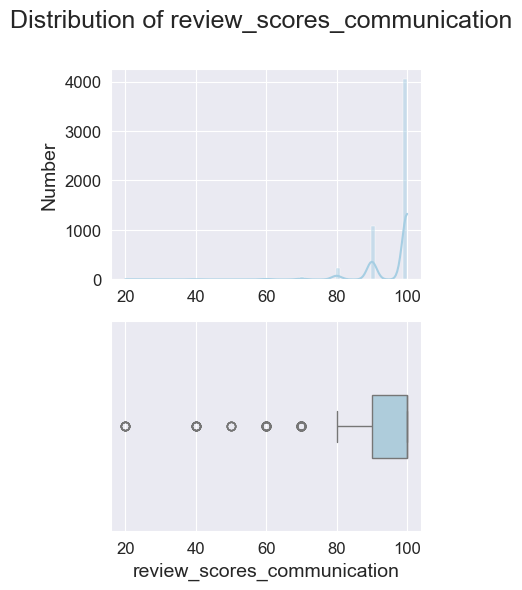

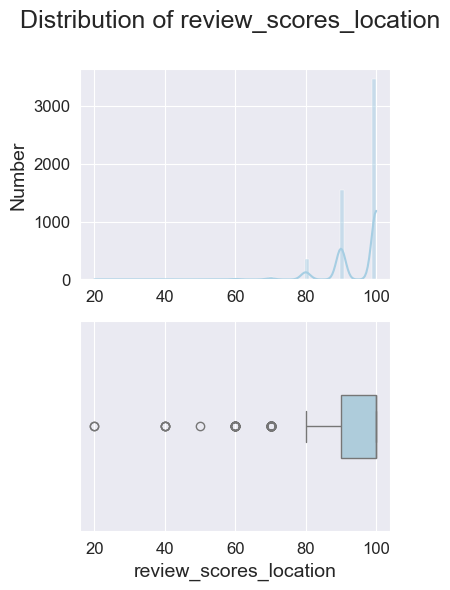

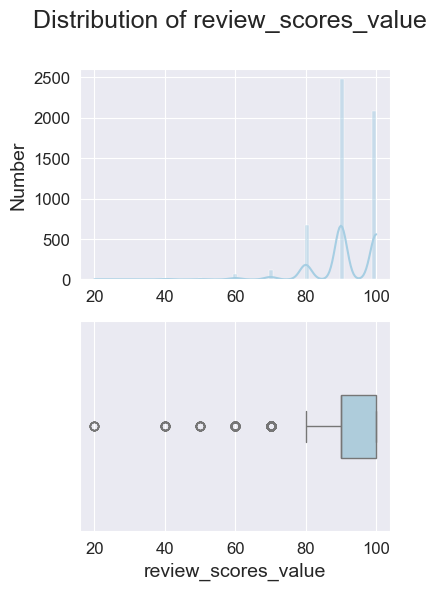

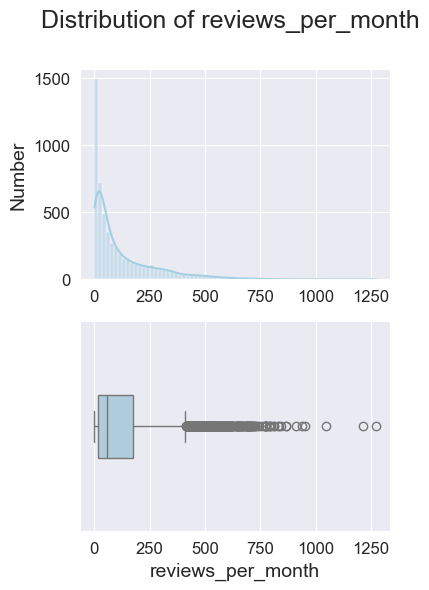

In [296]:
num_col = ['price', 'minimum_nights', 'maximum_nights',
           'availability_30', 'availability_60', 'availability_90', 'availability_365',
           'review_scores_rating', 'review_scores_accuracy',
           'review_scores_cleanliness', 'review_scores_checkin',
           'review_scores_communication', 'review_scores_location',
           'review_scores_value', 'reviews_per_month']

for col in num_col:
    
    # visualizing the distribution of transaction amounts
    fig, axs = plt.subplots(2, 1, figsize=(4, 6))
    fig.suptitle(f"Distribution of {col}")
    
    # histogram
    (sns.histplot(data=df_clean[col], kde=True, ax=axs[0])
        .set(xlabel=None, ylabel='Number')
    )
    
    # boxplot
    (sns.boxplot(data=df_clean[col], ax=axs[1], width=0.3, orient='h')
        #.set(yticklabels=[], xlabel=col)
    )
    plt.show()

### Reviews

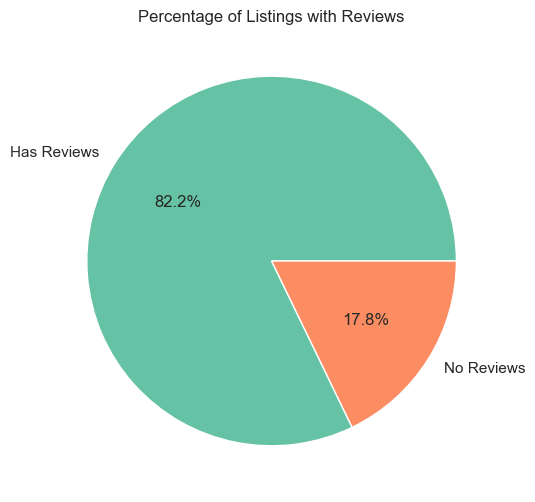

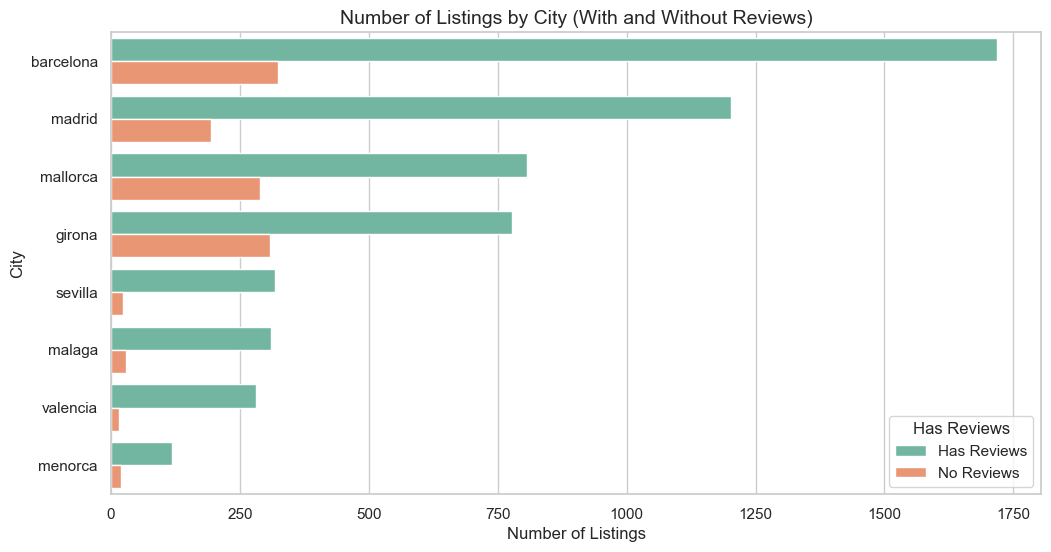

In [297]:
# Create a new column: "Has Reviews" (True/False)
df_clean['has_reviews'] = df_clean['number_of_reviews'] > 0

# Set up visualization style
sns.set_theme(style="whitegrid")

### Listings with and without reviews
plt.figure(figsize=(6, 6))
df_clean['has_reviews'].value_counts().plot(kind='pie', autopct='%1.1f%%', labels=["Has Reviews", "No Reviews"], colors=["#66c2a5", "#fc8d62"])
plt.title("Percentage of Listings with Reviews")
plt.ylabel("")
plt.show()

plt.figure(figsize=(12, 6))
sns.countplot(
    data=df_clean,
    y="city",
    hue="has_reviews",
    order=df_clean["city"].value_counts().index,
    hue_order=[True, False],  
    palette=["#66c2a5", "#fc8d62"] 
)

plt.title("Number of Listings by City (With and Without Reviews)", fontsize=14)
plt.xlabel("Number of Listings")
plt.ylabel("City")
plt.legend(title="Has Reviews", labels=["Has Reviews", "No Reviews"]) 
plt.show()

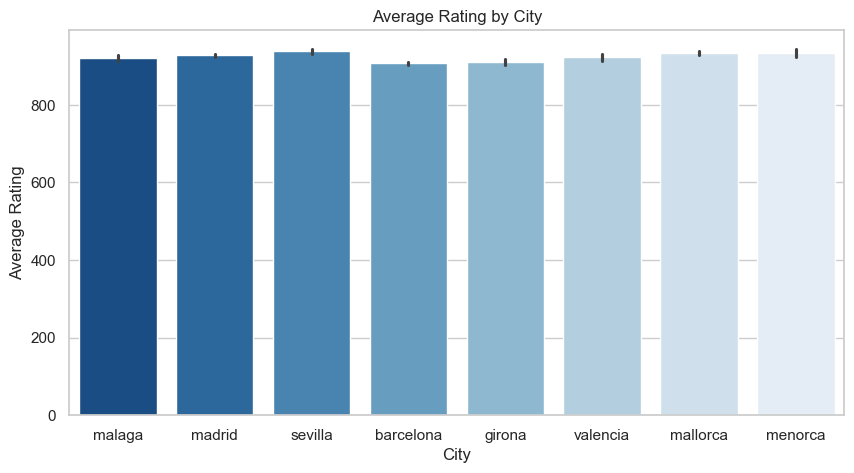

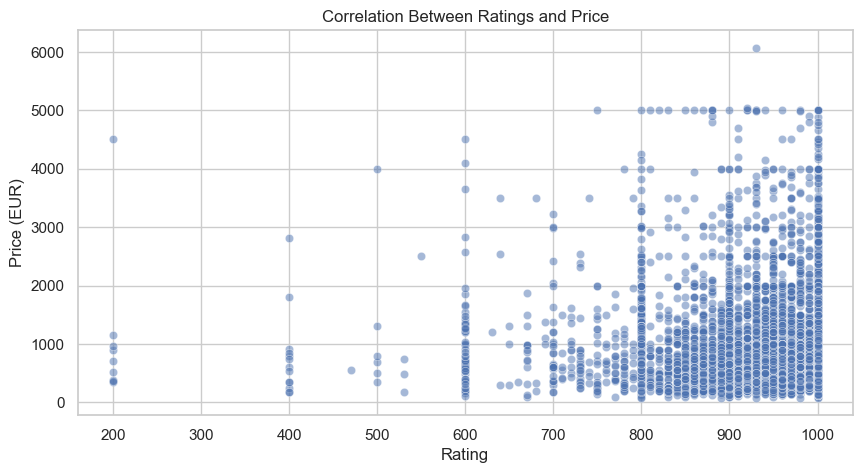

In [298]:
### Average rating by city
plt.figure(figsize=(10, 5))
sns.barplot(x='city', y='review_scores_rating', data=df_clean, estimator=lambda x: x.mean(), palette="Blues_r")
plt.title("Average Rating by City")
plt.xlabel("City")
plt.ylabel("Average Rating")
plt.show()

### Correlation between ratings and price
plt.figure(figsize=(10, 5))
sns.scatterplot(x='review_scores_rating', y='price', data=df_clean, alpha=0.5)
plt.title("Correlation Between Ratings and Price")
plt.xlabel("Rating")
plt.ylabel("Price (EUR)")
plt.show()

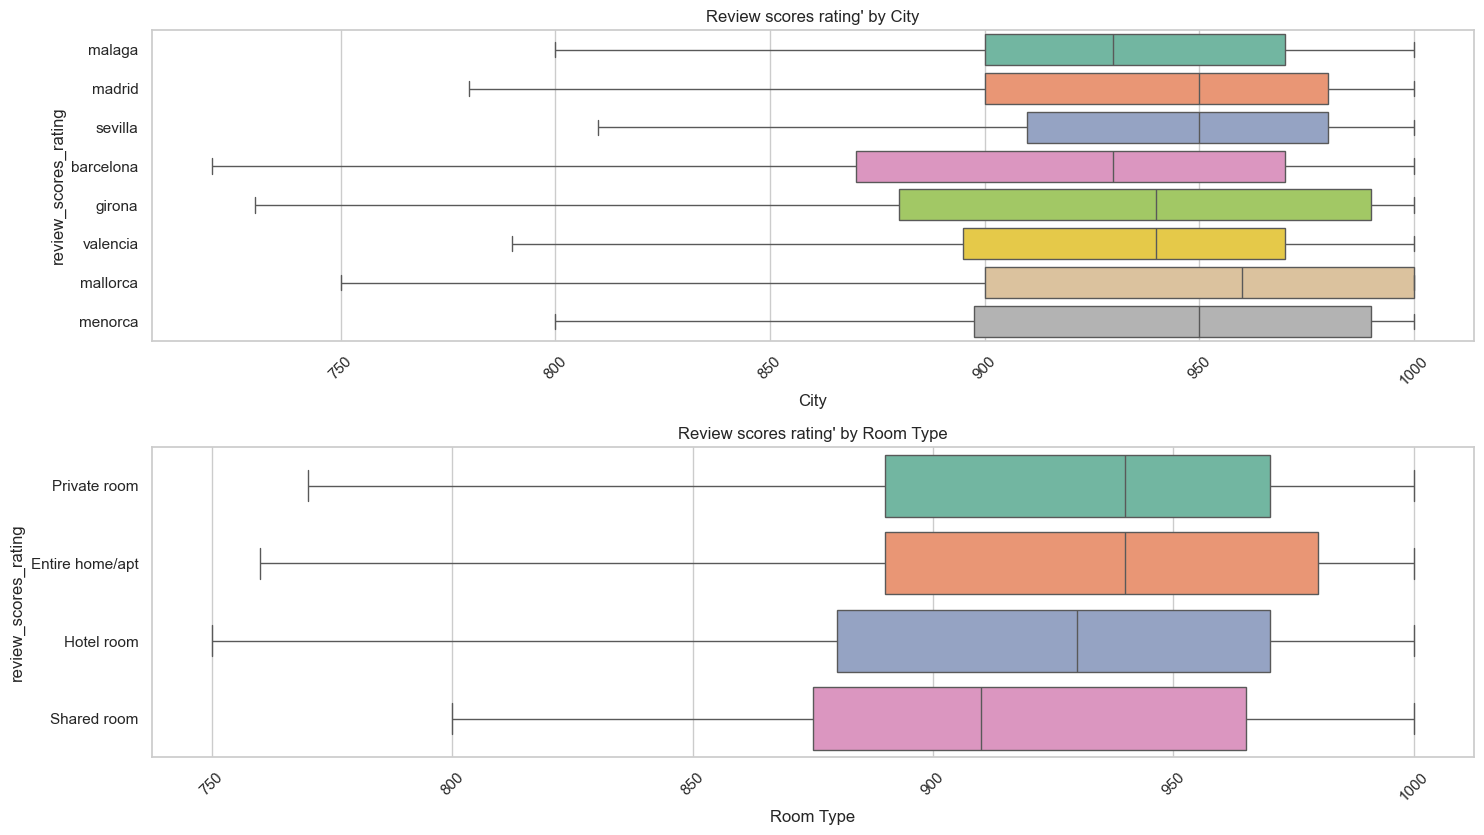

In [299]:
# Define categorical variables to analyze
categorical_vars = ["city", "room_type"]

# Set up the figure
plt.figure(figsize=(15, 12))

# Loop through each categorical variable and create a boxplot
for i, category in enumerate(categorical_vars, 1):
    plt.subplot(3, 1, i)  # Create subplots (3 rows, 1 column)
    sns.boxplot(x='review_scores_rating', y=category, data=df_clean, showfliers=False, palette="Set2")
    plt.xticks(rotation=45)  # Rotate labels for readability
    plt.title(f"Review scores rating' by {category.replace('_', ' ').title()}")
    plt.xlabel(category.replace('_', ' ').title())
    plt.ylabel("review_scores_rating")

# Adjust layout and show the plots
plt.tight_layout()
plt.show()


### Insert Date

In [300]:
df_clean.insert_date.min(), df_clean.insert_date.max()

(Timestamp('2017-01-04 00:00:00'), Timestamp('2021-02-27 00:00:00'))

Let's investigate our insert dates using `price` and `availability_30`.

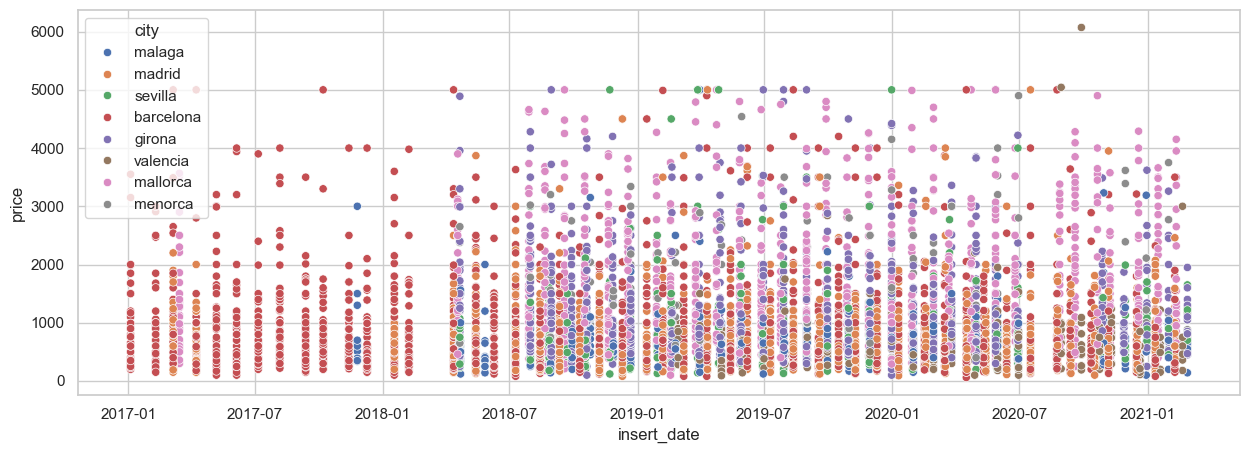

In [301]:
plt.figure(figsize=(15,5))
sns.scatterplot(data=df_clean, x='insert_date', y='price', hue='city')
plt.show()

In [302]:
df_clean.groupby(df_clean.insert_date.dt.year).price.count()

insert_date
2017     773
2018    1910
2019    2151
2020    1631
2021     268
Name: price, dtype: int64

In [303]:
df_clean.groupby([df_clean.insert_date.dt.year, df_clean.insert_date.dt.month]).availability_30.sum()

insert_date  insert_date
2017         1               773
             2               566
             3              1919
             4               957
             5               438
             6               439
             7               401
             8               403
             9               388
             10              635
             11              978
             12              715
2018         1              1467
             2               741
             4              2714
             5              1248
             6               404
             7              2477
             8              2796
             9              3000
             10             2392
             11             3243
             12             1793
2019         1              1561
             2              2312
             3              2661
             4              1749
             5              2434
             6              1186
             7    

In [304]:
df_clean.query("insert_date < last_review_date")

,apartment_id,name,description,host_id,neighbourhood_name,neighbourhood_district,room_type,accommodates,bathrooms,bedrooms,beds,amenities_list,price,minimum_nights,maximum_nights,has_availability,availability_30,availability_60,availability_90,availability_365,number_of_reviews,first_review_date,last_review_date,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,is_instant_bookable,reviews_per_month,country,city,insert_date,standardized_city,standardized_neighbourhood,autonomous_community,has_reviews
1313,6547870,Bella Vista. N� de registro: HUTB005799,Bella Vista es un apartamento �nico en Barcelo...,34249903,el Baix Guinard�,Horta-Guinard�,Entire home/apt,7,1.00,3.00,4.00,"TV,Internet,Wireless Internet,Air conditioning...",750.00,4,1125,0,30,45,47,238,25,2015-10-10,2017-01-05,860.00,90.00,80.00,90.00,90.00,90.00,90.00,1,165.00,spain,barcelona,2017-01-04,Barcelona,El Baix Guinardó,Cataluña,True
3570,17398411,Newly renovated design loft CHUECA 3 IZQ,"Bright apartment in the center of Madrid, in t...",107335103,Universidad,Centro,Entire home/apt,4,1.00,1.00,2.00,"Smoke alarm, TV, Washer, Wifi, Smart lock, Iro...",490.00,15,90,1,23,50,79,79,228,2017-04-04,2020-10-18,830.00,80.00,80.00,90.00,90.00,90.00,80.00,1,526.00,spain,madrid,2020-10-17,Madrid,Universidad,Comunidad de Madrid,True
4961,21170845,DEIA famous village Font Fresca house ETV/8481,This charming 2 bedroom house in the beautiful...,24227166,Dey�,NaN,Entire home/apt,4,2.00,2.00,4.00,"Dishes and silverware, BBQ grill, TV, Wifi, Ir...",1030.00,4,28,1,30,60,83,131,92,2017-10-21,2020-12-20,970.00,100.00,100.00,100.00,100.00,100.00,100.00,0,237.00,spain,mallorca,2020-12-19,Palma,Deià,Islas Baleares,True


In [229]:
df.query("insert_date < first_review_date")

,apartment_id,name,description,host_id,neighbourhood_name,neighbourhood_district,room_type,accommodates,bathrooms,bedrooms,beds,amenities_list,price,minimum_nights,maximum_nights,has_availability,availability_30,availability_60,availability_90,availability_365,number_of_reviews,first_review_date,last_review_date,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,is_instant_bookable,reviews_per_month,country,city,insert_date


## Conclusion
The following changes were made to the dataset:

**Duplicates**
- Removed older listings for duplicated `apartment_id`, keeping only the most recent entry (`insert_date`).

**Data Types**
- Converted the is_instant_bookable column to boolean: 'FALSO' → 0, 'VERDADERO' → 1

**Missing Values**
- Filled NaN values in `has_availability`: NaN → 0, 'VERDADERO' → 1
- Imputed missing values in `price` using the KNNImputer algorithm.

**Data Standardization**
- Added columns with city names and neighbourhood_district using correct Spanish accents.
- Added a new column: `autonomous_community`.

## Save Clean Dataframe

In [103]:
data_info(df_clean)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7693 entries, 0 to 7692
Data columns (total 38 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   apartment_id                 7693 non-null   int64         
 1   name                         7690 non-null   object        
 2   description                  7643 non-null   object        
 3   host_id                      7693 non-null   int64         
 4   neighbourhood_name           7693 non-null   object        
 5   neighbourhood_district       4669 non-null   object        
 6   room_type                    7693 non-null   object        
 7   accommodates                 7693 non-null   int64         
 8   bathrooms                    7652 non-null   object        
 9   bedrooms                     7654 non-null   object        
 10  beds                         7685 non-null   float64       
 11  amenities_list               7677 non-null 

apartment_id                   7693
name                           7667
description                    7610
host_id                        5887
neighbourhood_name              492
neighbourhood_district           61
room_type                         4
accommodates                     20
bathrooms                        13
bedrooms                         14
beds                             24
amenities_list                 7567
price                           505
minimum_nights                   41
maximum_nights                  135
has_availability                  2
availability_30                  31
availability_60                  61
availability_90                  91
availability_365                366
number_of_reviews               318
first_review_date              1938
last_review_date               1467
review_scores_rating             46
review_scores_accuracy            9
review_scores_cleanliness         9
review_scores_checkin             8
review_scores_communication 


Number of missing values


,number,percentage
neighbourhood_district,3024,39.31
review_scores_location,1649,21.44
review_scores_value,1649,21.44
review_scores_checkin,1648,21.42
review_scores_accuracy,1643,21.36
review_scores_communication,1639,21.31
review_scores_cleanliness,1637,21.28
review_scores_rating,1634,21.24
last_review_date,1555,20.21
reviews_per_month,1554,20.20



There are no full duplicates in the data



In [104]:
# save file to Data folder
df_clean.to_csv(f'../Data/data_clean.csv', index=False) 

## Transfer DataFrame to Stage 1 in MySQL
- first, we need install sqlalchemy,
- second, connect to mysql
- third, a function to copy df to mysql table

In [307]:
#!pip install sqlalchemy

In [310]:
# Automatically find the .env file
dotenv_path = find_dotenv()

# If found, load the .env file
if dotenv_path:
    load_dotenv(dotenv_path)
else:
    print(".env file not found")
# configuration for MySQL connection
config = {
  'user': os.getenv('MYSQL_USER'),
  'password': os.getenv('MYSQL_PASSWORD'),
  'host': os.getenv('HOST'),
  'database': os.getenv('DB'),
  'raise_on_warnings': True
}

In [ ]:
# mi conexion se llama connection
def df_to_mysql(df: pd.DataFrame, table_name: str):
  try:
      # Assuming 'df_new' is your DataFrame
      # Create a SQLAlchemy engine
      engine = sqlalchemy.create_engine(f"mysql+mysqlconnector://{user}:{password}@{host}/{database}")
      
      # Use the engine with to_sql
      df.to_sql(table_name, engine, if_exists='replace', index=False)  
      print("DataFrame successfully written to MySQL table: ", table_name )

  except mysql.connector.Error as err:
      print(f"Error writing DataFrame to MySQL: {err}")

  finally:
      if connection.is_connected():
          connection.close()
          print("MySQL connection closed.")

In [ ]:
df_to_mysql(df_clean, "ST1_Tourist_Accommodation")